In [1]:
#install required packages
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

2.1.0


In [5]:
import torch
dir1 = '/mnt/data1/karres/Example_3/feature_store/trainset/event000021000-graph.pyg'
dir2 = '/mnt/data1/karres/Example_3/metric_learning/trainset/event000021000.pyg'

dir3 = '/mnt/data1/karres/cosmics_test/feature_store_cosmic/trainset/event000000002-graph.pyg'
dir4 = '/mnt/data1/karres/cosmics_test/fully_connected_cosmic_michel/trainset/event000000001.pyg'

truth = torch.load(dir1)
metric = torch.load(dir2)

cosmic_truth = torch.load(dir3)
fc = torch.load(dir4)

print('Truth:',truth)
print()
print('Metric:',metric)
print()
'''
print('track_edges:', metric.track_edges)
print('truth_map:', metric.truth_map)
print('ptr:', metric.ptr) #erster und letzter hit
print('batch:', metric.batch) #nur nullen?
print('truth_map:', metric.truth_map)
print('y:', metric.y)
'''
print('Cosmic Truth:',cosmic_truth)
print('Fully Connected:',fc)

print('track_edges:',fc.track_edges)
print('edge_index:',fc.edge_index)
print('truth_map:',fc.truth_map)
print('y:',fc.y)
print(fc.particle_id)

'''
Metric learning pyg
70647 elements (edges): y
2x70647 elements: edge_index
15254 elements (nodes): region, r, eta, module_index, geta, x, cell_count, gphi, leta, lz, phi, lphi, weight, cell_val, lx, ly, z, hit_id, batch
13914 elements (tracks): nhits, particle_id, pt, radius, truth_map
2x13914 elements: track_edges
1 element: num_nodes
2 elements: ptr

Questions:
    Why more elements per key in truth pyg than in metric learning pyg? -> hard pt cuts
    Why different amount of elements in y and x/z? -> not y but truth information
    What is truth map? -> same amount of elements as nhits, particle_id, pt, radius
        -> indicates if segment is in graph and if so what edge index it corresponds to (-1 if not in graph)

    Track edges just endpoints of true tracks?
        If yes, why are there no edge indices in truth pyg?
        Is there even a truth graph???
    Are segments the whole true track of one traversing particle i.e. consisting of multiple nodes/edges?
        If not, what does edge_index refer to in truth_map? 

        


To Do:
    Add y to fc graph DONE
    Implement truth mapping DONE
    Parallelization of graph construction DONE
    Added cylindrical coordinates and eta to FC graph DONE -> maybe move to truth pyg instead
    Write evaluation code for graph construction DONE
        -> Still need to create plots for w/ and w/o cuts
    
    Run it all through GNN
'''

Truth: Data(region=[125576], r=[125576], eta=[125576], y=[125576], module_index=[125576], geta=[125576], x=[125576], cell_count=[125576], gphi=[125576], leta=[125576], lz=[125576], phi=[125576], lphi=[125576], weight=[125576], cell_val=[125576], lx=[125576], ly=[125576], z=[125576], hit_id=[125576], track_edges=[2, 96834], nhits=[96834], particle_id=[96834], pt=[96834], radius=[96834], config=[1], event_id='000021000')

Metric: DataBatch(region=[15254], r=[15254], eta=[15254], y=[70647], module_index=[15254], geta=[15254], x=[15254], cell_count=[15254], gphi=[15254], leta=[15254], lz=[15254], phi=[15254], lphi=[15254], weight=[15254], cell_val=[15254], lx=[15254], ly=[15254], z=[15254], hit_id=[15254], track_edges=[2, 13914], nhits=[13914], particle_id=[13914], pt=[13914], radius=[13914], config=[2], event_id=[1], num_nodes=15254, batch=[15254], ptr=[2], edge_index=[2, 70647], truth_map=[13914])

Cosmic Truth: Data(y=[4], x=[4], hit_id=[4], z=[4], track_edges=[2, 3], nhits=[3], radius=

'\nMetric learning pyg\n70647 elements (edges): y\n2x70647 elements: edge_index\n15254 elements (nodes): region, r, eta, module_index, geta, x, cell_count, gphi, leta, lz, phi, lphi, weight, cell_val, lx, ly, z, hit_id, batch\n13914 elements (tracks): nhits, particle_id, pt, radius, truth_map\n2x13914 elements: track_edges\n1 element: num_nodes\n2 elements: ptr\n\nQuestions:\n    Why more elements per key in truth pyg than in metric learning pyg? -> hard pt cuts\n    Why different amount of elements in y and x/z? -> not y but truth information\n    What is truth map? -> same amount of elements as nhits, particle_id, pt, radius\n        -> indicates if segment is in graph and if so what edge index it corresponds to (-1 if not in graph)\n\n    Track edges just endpoints of true tracks?\n        If yes, why are there no edge indices in truth pyg?\n        Is there even a truth graph???\n    Are segments the whole true track of one traversing particle i.e. consisting of multiple nodes/edge

In [ ]:
'''
Data reading stage:
Nodes: Hits
Segments: meta truth information -> all true edges that should be in the graph
track_edges: list of all segments ->'edges' not really right term
particle_id: same length as track_edges -> assigns particle id to each segment

Graph construction stage:
edge_index: list of all edges actually created
truth_map: same length as track_edges -> Assigns index of edge in edge_index to each segment in track_edges
'''

In [1]:
import torch

def get_single_eff_purity(fcgraph):
    truth_info = fcgraph.y
    truth_map = fcgraph.truth_map


    eff = torch.sum(truth_info) / len(truth_map[truth_map != -1]) # eff = #built segments / #segments

    pur = torch.sum(truth_info) / len(truth_info) # pur = #built segments / #edges

    return eff, pur

dir = '/mnt/data1/karres/cosmics_test/fully_connected_cosmic/trainset/event000000002.pyg'
dir2 = '/mnt/data1/karres/cosmics_test/fully_connected_cosmic_michel/trainset/event000000001.pyg'

cosmic = torch.load(dir)
cosmic_michel = torch.load(dir2)

print(get_single_eff_purity(cosmic))
print(get_single_eff_purity(cosmic_michel))
print()
print(cosmic.edge_index)
print(cosmic.y)
print(cosmic.track_edges)  
print(cosmic.truth_map)

(tensor(1.), tensor(0.5000))
(tensor(1.), tensor(0.0406))

tensor([[0, 0, 0, 1, 1, 2],
        [1, 2, 3, 2, 3, 3]])
tensor([ True,  True, False, False,  True, False])
tensor([[0, 1, 2],
        [1, 3, 0]])
tensor([0, 4, 1])


/local/anaconda3/envs/cosmicgnn/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


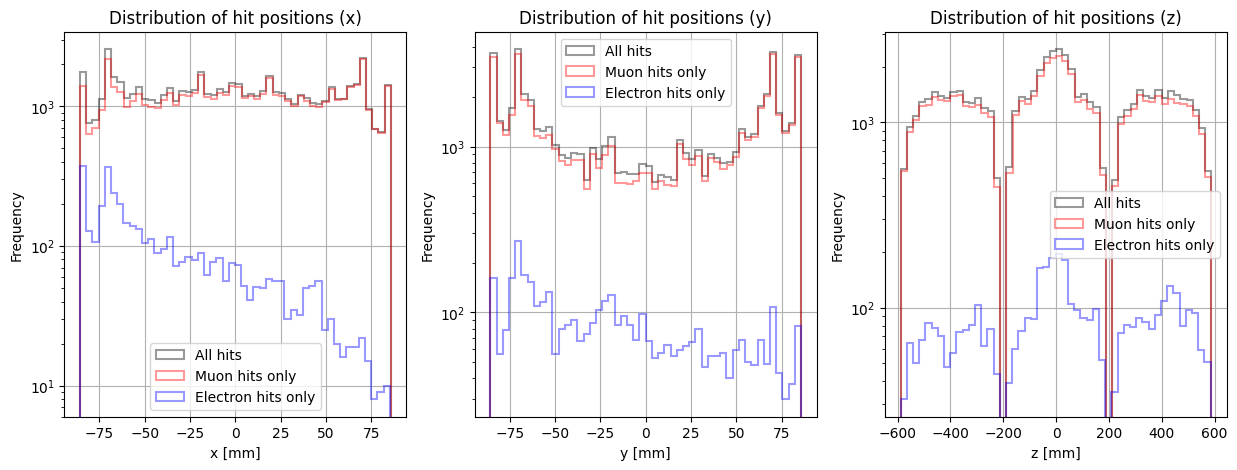

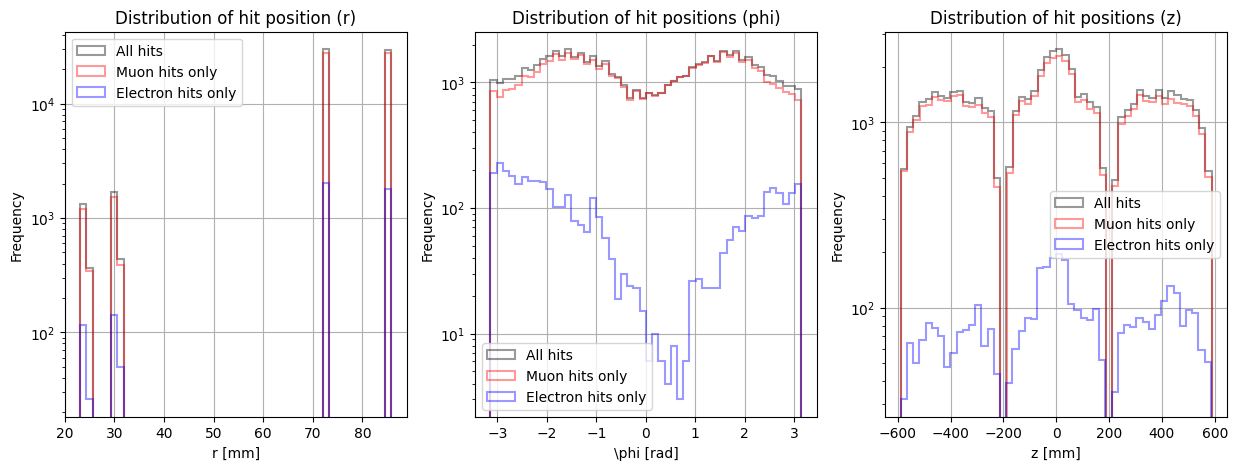

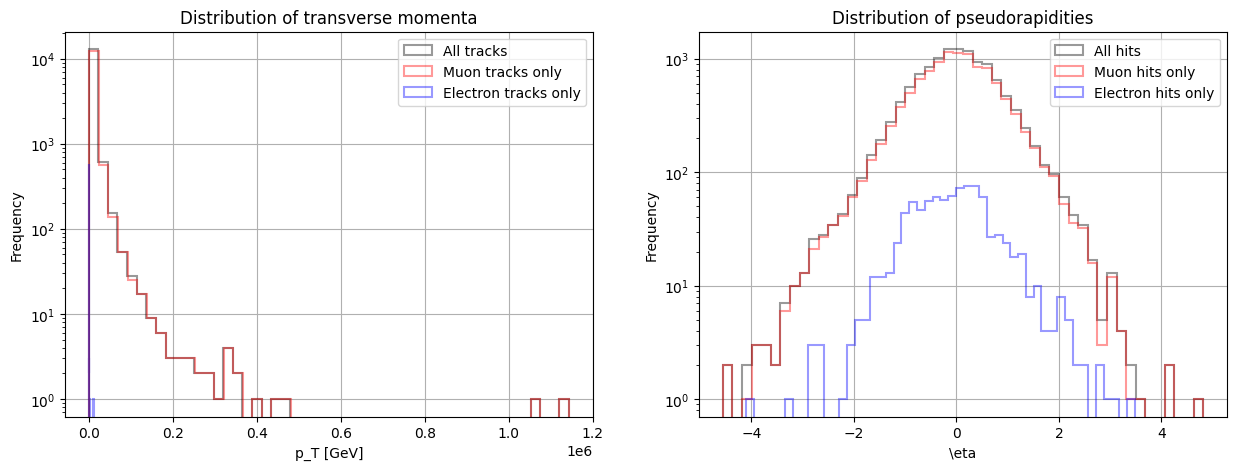

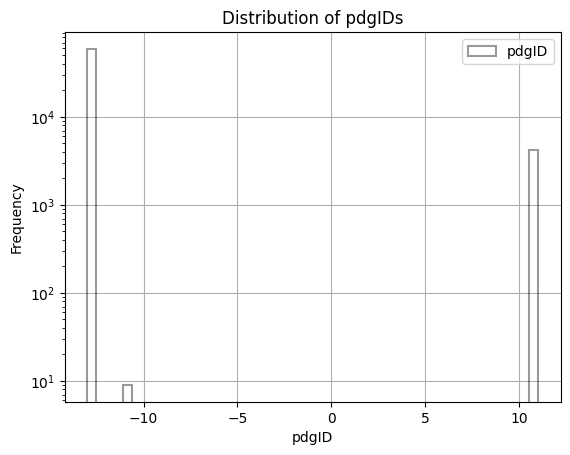

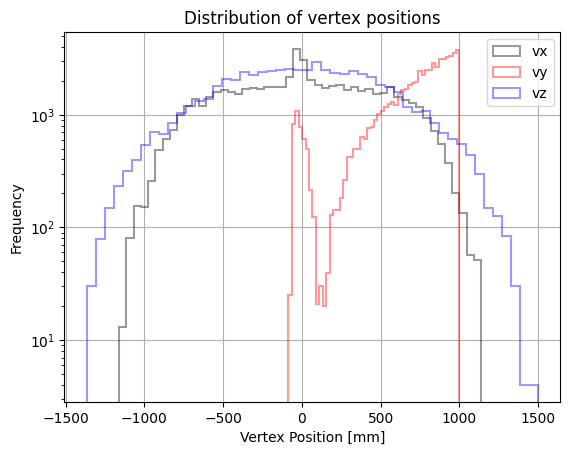

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dir = '/mnt/data1/karres/cosmics_test/cosmics_data/cosmic_f1.csv'
#dir = '/mnt/data1/karres/cosmics_test/cosmics_data/cosmic_michel_f2.csv'

savedir = 'cosmic_plots/'
#savedir = 'cosmic_michel_plots/'

# Load the CSV file
df = pd.read_csv(dir)

#Cut ID columnsS
df = df.drop(columns=['event', 'layer', 'ladder', 'module', 'station', 'mid'])

#Add eta, phi, r, pt columns
df['eta'] = np.arctanh(df['z']/np.sqrt(df['x']**2 + df['y']**2))
df['phi'] = np.arctan2(df['y'], df['x'])
df['r'] = np.sqrt(df['x']**2 + df['y']**2)
df['pt'] = np.sqrt(df['px']**2 + df['py']**2)

df_no_electrons = df[(df['pid'] != 11) & (df['pid'] != -11)]
df_no_muons = df[(df['pid'] != 13) & (df['pid'] != -13)]

width=1.5

#Plot histograms of positions
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(df['x'], bins=50, alpha=0.4, edgecolor='black', linewidth=width, histtype='step', label='All hits')
axs[0].hist(df_no_electrons['x'], bins=50, alpha=0.4, edgecolor='red', linewidth=width, histtype='step', label='Muon hits only')
axs[0].hist(df_no_muons['x'], bins=50, alpha=0.4, edgecolor='blue', linewidth=width, histtype='step', label='Electron hits only')
axs[0].set_xlabel('x [mm]')
axs[0].set_ylabel('Frequency')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_title('Distribution of hit positions (x)')
axs[0].grid(True)

axs[1].hist(df['y'], bins=50, alpha=0.4, edgecolor='black', linewidth=width, histtype='step', label='All hits')
axs[1].hist(df_no_electrons['y'], bins=50, alpha=0.4, edgecolor='red', linewidth=width, histtype='step', label='Muon hits only')
axs[1].hist(df_no_muons['y'], bins=50, alpha=0.4, edgecolor='blue', linewidth=width, histtype='step', label='Electron hits only')
axs[1].set_xlabel('y [mm]')
axs[1].set_ylabel('Frequency')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_title('Distribution of hit positions (y)')
axs[1].grid(True)

axs[2].hist(df['z'], bins=50, alpha=0.4, edgecolor='black', linewidth=width, histtype='step', label='All hits')
axs[2].hist(df_no_electrons['z'], bins=50, alpha=0.4, edgecolor='red', linewidth=width, histtype='step', label='Muon hits only')
axs[2].hist(df_no_muons['z'], bins=50, alpha=0.4, edgecolor='blue', linewidth=width, histtype='step', label='Electron hits only')
axs[2].set_xlabel('z [mm]')
axs[2].set_ylabel('Frequency')
axs[2].set_yscale('log')
axs[2].legend()
axs[2].set_title('Distribution of hit positions (z)')
axs[2].grid(True)

fig.savefig(savedir+'hit_positions.png', dpi=400)
plt.show()

#Plot histograms of cylindrical coordinates
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].hist(df['r'], bins=50, alpha=0.4, edgecolor='black', linewidth=width, histtype='step', label='All hits')
axs[0].hist(df_no_electrons['r'], bins=50, alpha=0.4, edgecolor='red', linewidth=width, histtype='step', label='Muon hits only')
axs[0].hist(df_no_muons['r'], bins=50, alpha=0.4, edgecolor='blue', linewidth=width, histtype='step', label='Electron hits only')
axs[0].set_xlabel('r [mm]')
axs[0].set_ylabel('Frequency')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_title('Distribution of hit position (r)')
axs[0].grid(True)

axs[1].hist(df['phi'], bins=50, alpha=0.4, edgecolor='black', linewidth=width, histtype='step', label='All hits')
axs[1].hist(df_no_electrons['phi'], bins=50, alpha=0.4, edgecolor='red', linewidth=width, histtype='step', label='Muon hits only')
axs[1].hist(df_no_muons['phi'], bins=50, alpha=0.4, edgecolor='blue', linewidth=width, histtype='step', label='Electron hits only')
axs[1].set_xlabel('\phi [rad]')
axs[1].set_ylabel('Frequency')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_title('Distribution of hit positions (phi)')
axs[1].grid(True)

axs[2].hist(df['z'], bins=50, alpha=0.4, edgecolor='black', linewidth=width, histtype='step', label='All hits')
axs[2].hist(df_no_electrons['z'], bins=50, alpha=0.4, edgecolor='red', linewidth=width, histtype='step', label='Muon hits only')
axs[2].hist(df_no_muons['z'], bins=50, alpha=0.4, edgecolor='blue', linewidth=width, histtype='step', label='Electron hits only')
axs[2].set_xlabel('z [mm]')
axs[2].set_ylabel('Frequency')
axs[2].set_yscale('log')
axs[2].legend()
axs[2].set_title('Distribution of hit positions (z)')
axs[2].grid(True)

fig.savefig(savedir+'hit_positions_cylindrical.png', dpi=400)

#Plot histograms of pt and eta
df_tracks_only = df.drop_duplicates(subset=['tid'], keep='first')
df_no_electrons_to = df_no_electrons.drop_duplicates(subset=['tid'], keep='first')
df_no_muons_to = df_no_muons.drop_duplicates(subset=['tid'], keep='first')

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(df_tracks_only['pt'], bins=50, alpha=0.4, edgecolor='black', linewidth=width, histtype='step', label='All tracks')
axs[0].hist(df_no_electrons_to['pt'], bins=50, alpha=0.4, edgecolor='red', linewidth=width, histtype='step', label='Muon tracks only')
axs[0].hist(df_no_muons_to['pt'], bins=50, alpha=0.4, edgecolor='blue', linewidth=width, histtype='step', label='Electron tracks only')
axs[0].set_xlabel('p_T [GeV]')
axs[0].set_ylabel('Frequency')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_title('Distribution of transverse momenta')
axs[0].grid(True)

axs[1].hist(df['eta'], bins=50, alpha=0.4, edgecolor='black', linewidth=width, histtype='step', label='All hits')
axs[1].hist(df_no_electrons['eta'], bins=50, alpha=0.4, edgecolor='red', linewidth=width, histtype='step', label='Muon hits only')
axs[1].hist(df_no_muons['eta'], bins=50, alpha=0.4, edgecolor='blue', linewidth=width, histtype='step', label='Electron hits only')
axs[1].set_xlabel('\eta')
axs[1].set_ylabel('Frequency')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_title('Distribution of pseudorapidities')
axs[1].grid(True)

fig.savefig(savedir+'track_parameters.png', dpi=400)
plt.show()

#Plot histograms of pdgID
plt.hist(df['pid'], bins=50, alpha=0.4, edgecolor='black', linewidth=width, histtype='step', label='pdgID')
plt.xlabel('pdgID')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()
plt.title('Distribution of pdgIDs')
plt.grid(True)
plt.savefig(savedir+'pdgID.png', dpi=400)
plt.show()

#Plot vertex locations
plt.hist(df['vx'], bins=50, alpha=0.4, edgecolor='black', linewidth=width, histtype='step', label='vx')
plt.hist(df['vy'], bins=50, alpha=0.4, edgecolor='red', linewidth=width, histtype='step', label='vy')
plt.hist(df['vz'], bins=50, alpha=0.4, edgecolor='blue', linewidth=width, histtype='step', label='vz')
plt.xlabel('Vertex Position [mm]')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()
plt.title('Distribution of vertex positions')
plt.grid(True)
plt.savefig(savedir+'vertex_positions.png', dpi=400)
plt.show()

In [ ]:
import torch
import glob

#Plot histograms of edge level features

dir = '/mnt/data1/karres/cosmics_test/fully_connected_cosmic/'

num_track_edges = []
num_edges = []
num_nodes_list = []

#iterate over all graphs in directory
for dataset in ['trainset', 'valset', 'testset']:
    for graph in glob.glob(dir+dataset+'/*.pyg'):
        graph = torch.load(graph)

        num_track_edges.append(graph.track_edges.shape[1])
        num_edges.append(graph.edge_index.shape[1])
        num_nodes_list.append(graph.num_nodes)

In [40]:
import torch

dir = '/mnt/data1/karres/cosmics_test/fully_connected_cosmic_michel/trainset/event000000001.pyg'

graph = torch.load(dir)

print(graph)

Data(hit_id=[59], z=[59], y=[1600], phi=[59], eta=[59], r=[59], x=[59], track_edges=[2, 65], radius=[65], q=[65], nhits=[65], particle_id=[65], pt=[65], particle_type=[65], config=[2], event_id='000000001', node_pos=[59, 3], theta=[59], num_nodes=59, batch=[59], ptr=[2], edge_index=[2, 1600], truth_map=[65])


In [8]:
#Control plots:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

#Hit/particle level plots:

def get_hit_data(dir, samplesize, key, filter_particle=None):
    #Iterate through all truth and particle csvs from the directory
    histogram_data = []
    i = 1

    for truth, particles in zip(glob.glob(dir+'/*truth.csv'), glob.glob(dir+'/*particles.csv')):
        truth_df = pd.read_csv(truth)
        particle_df = pd.read_csv(particles)

        if filter_particle == 'muon':
            particle_df = particle_df[(particle_df['particle_type'] == 13) | (particle_df['particle_type'] == -13)]
        elif filter_particle == 'electron':
            particle_df = particle_df[(particle_df['particle_type'] == 11) | (particle_df['particle_type'] == -11)]
        
        if key in particle_df.columns:
            histogram_data.extend(particle_df[key].tolist())
        elif key in truth_df.columns:
            histogram_data.extend(truth_df[key].tolist())
        else:
            print('Key not found in CSV files')

        i += 1
        if i > samplesize:
            break
    
    return histogram_data

#Position plots
def get_position_data(dir, samplesize):
    #cartesian
    x_data = get_hit_data(dir, samplesize, 'x')
    y_data = get_hit_data(dir, samplesize, 'y')
    z_data = get_hit_data(dir, samplesize, 'z')
    
    #spherical
    r = np.sqrt(np.array(x_data)**2 + np.array(y_data)**2+ np.array(z_data)**2)
    phi = np.arctan2(np.array(z_data), np.array(x_data))
    theta = np.arccos(np.array(y_data)/r)
    
    #cylindrical
    rho = np.sqrt(np.array(x_data)**2 + np.array(y_data)**2)
    phi = np.arctan2(y_data, x_data)
    z_cyl = z_data
    
    return x_data, y_data, z_data, rho, phi, z_cyl

def get_particle_data(dir, samplesize):
    pid = get_hit_data(dir, samplesize, 'particle_type')

    pt_mu = get_hit_data(dir, samplesize, 'pt', 'muon')
    pt_e = get_hit_data(dir, samplesize, 'pt', 'electron')

    nhits_mu = get_hit_data(dir, samplesize, 'nhits', 'muon')
    nhits_e = get_hit_data(dir, samplesize, 'nhits', 'electron')
    
    radius_mu = get_hit_data(dir, samplesize, 'radius', 'muon')
    radius_e = get_hit_data(dir, samplesize, 'radius', 'electron')

    vx_mu = get_hit_data(dir, samplesize, 'vx', 'muon')
    vy_mu = get_hit_data(dir, samplesize, 'vy', 'muon')
    vz_mu = get_hit_data(dir, samplesize, 'vz', 'muon')

    vx_e = get_hit_data(dir, samplesize, 'vx', 'electron')
    vy_e = get_hit_data(dir, samplesize, 'vy', 'electron')
    vz_e = get_hit_data(dir, samplesize, 'vz', 'electron')

    px_mu = get_hit_data(dir, samplesize, 'px', 'muon')
    py_mu = get_hit_data(dir, samplesize, 'py', 'muon')
    pz_mu = get_hit_data(dir, samplesize, 'pz', 'muon')

    px_e = get_hit_data(dir, samplesize, 'px', 'electron')
    py_e = get_hit_data(dir, samplesize, 'py', 'electron')
    pz_e = get_hit_data(dir, samplesize, 'pz', 'electron')

    p_tot_mu = np.sqrt(np.array(px_mu)**2 + np.array(py_mu)**2 + np.array(pz_mu)**2)
    p_tot_e = np.sqrt(np.array(px_e)**2 + np.array(py_e)**2 + np.array(pz_e)**2)
    
    pt = [pt_mu, pt_e]
    nhits = [nhits_mu, nhits_e]
    radius = [radius_mu, radius_e]
    v_mu = [vx_mu, vy_mu, vz_mu]
    v_e = [vx_e, vy_e, vz_e]
    p_mu = [px_mu, py_mu, pz_mu]
    p_e = [px_e, py_e, pz_e]
    p_tot = [p_tot_mu, p_tot_e]

    return pid, pt, nhits, radius, v_mu, v_e, p_mu, p_e, p_tot

def get_graph_data(dir, samplesize):
    num_edges = []
    num_nodes = []

    for graph in glob.glob(dir+'/*.pyg'):
        graph = torch.load(graph)
        num_edges.append(graph.edge_index.shape[1])
        num_nodes.append(graph.num_nodes)

    
    return num_edges, num_nodes

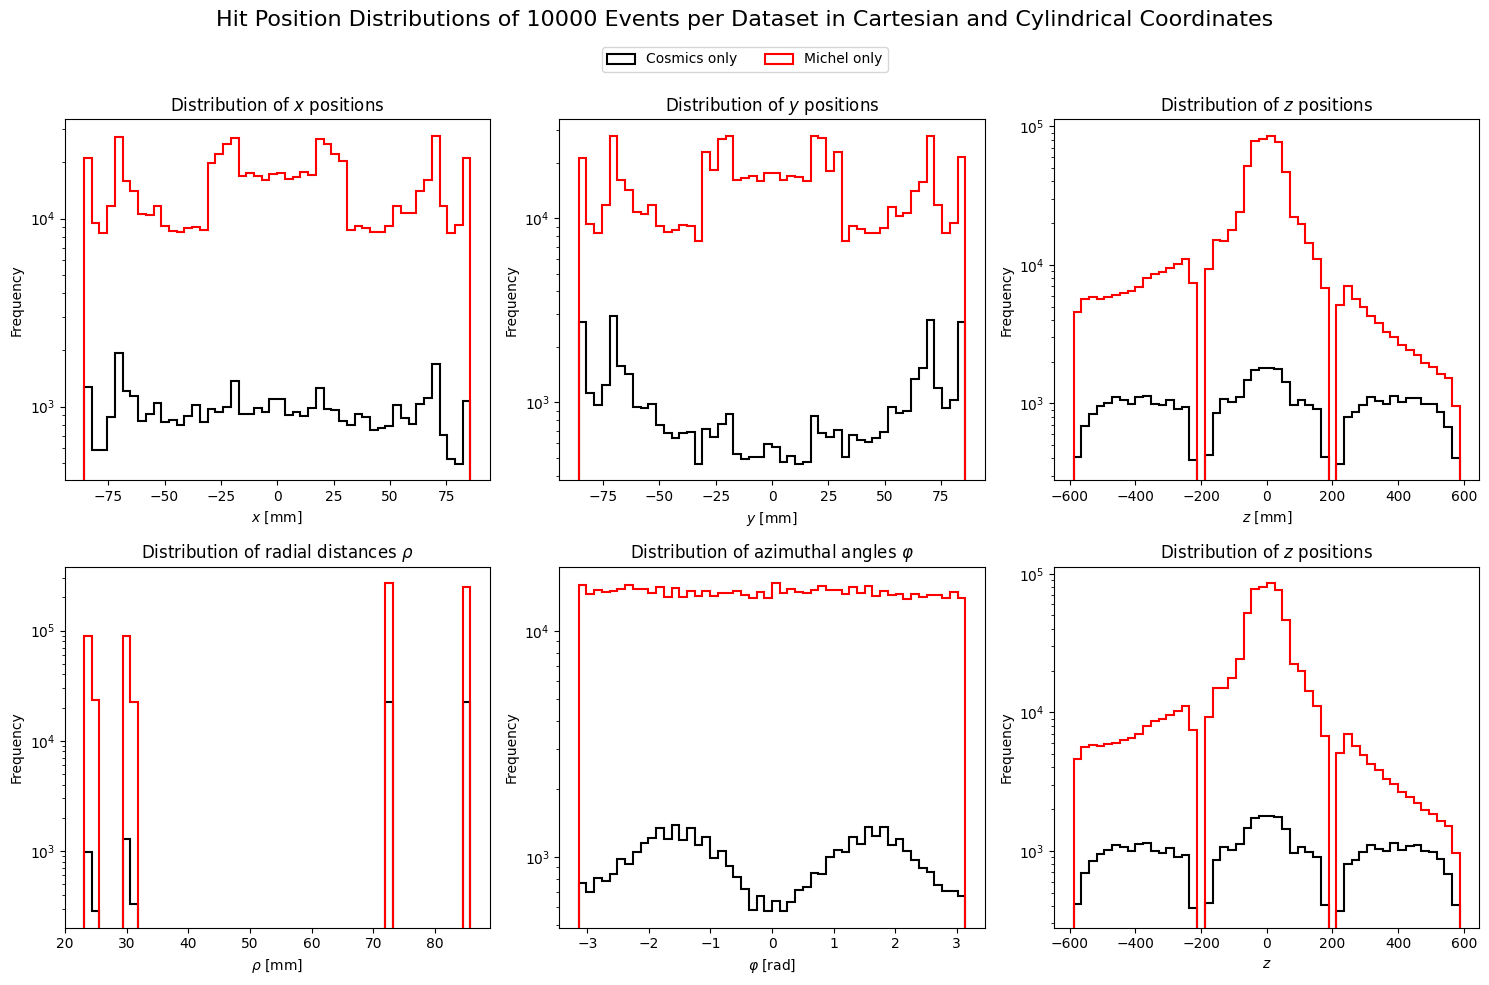

In [10]:
cosmic_dir = '/mnt/data1/karres/cosmics_test/feature_store_cosmic/trainset/'
michel_dir = '/mnt/data1/karres/cosmics_test/feature_store_michel/trainset/'
cosmic_michel_dir = '/mnt/data1/karres/cosmics_test/feature_store_cosmic_michel/trainset/'  

x_c, y_c, z_c, r_c, phi_c, eta_c = get_position_data(cosmic_dir, 10000)
x_m, y_m, z_m, r_m, phi_m, eta_m = get_position_data(michel_dir, 10000)
#x_cm, y_cm, z_cm, r_cm, phi_cm, eta_cm = get_position_data(cosmic_michel_dir, 10000)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0,0].hist(x_c, bins=50, linewidth=1.5, edgecolor='black', histtype='step', label='Cosmics only')
axs[0,0].hist(x_m, bins=50, linewidth=1.5, edgecolor='red', histtype='step', label='Michel only')
#axs[0,0].hist(x_cm, bins=50, linewidth=1.5, edgecolor='blue', histtype='step', label='Cosmics with Michel')
axs[0,0].set_xlabel(r'$x$ [mm]')
axs[0,0].set_title(r'Distribution of $x$ positions')

axs[0,1].hist(y_c, bins=50, linewidth=1.5, edgecolor='black', histtype='step')
axs[0,1].hist(y_m, bins=50, linewidth=1.5, edgecolor='red', histtype='step')
#axs[0,1].hist(y_cm, bins=50, linewidth=1.5, edgecolor='blue', histtype='step')
axs[0,1].set_xlabel(r'$y$ [mm]')
axs[0,1].set_title(r'Distribution of $y$ positions')

axs[0,2].hist(z_c, bins=50, linewidth=1.5, edgecolor='black', histtype='step')
axs[0,2].hist(z_m, bins=50, linewidth=1.5, edgecolor='red', histtype='step')
#axs[0,2].hist(z_cm, bins=50, linewidth=1.5, edgecolor='blue', histtype='step')
axs[0,2].set_xlabel(r'$z$ [mm]')
axs[0,2].set_title(r'Distribution of $z$ positions')

axs[1,0].hist(r_c, bins=50, linewidth=1.5, edgecolor='black', histtype='step')
axs[1,0].hist(r_m, bins=50, linewidth=1.5, edgecolor='red', histtype='step')
#axs[1,0].hist(r_cm, bins=50, linewidth=1.5, edgecolor='blue', histtype='step')
axs[1,0].set_xlabel(r'$\rho$ [mm]')
axs[1,0].set_title(r'Distribution of radial distances $\rho$')

axs[1,1].hist(phi_c, bins=50, linewidth=1.5, edgecolor='black', histtype='step')
axs[1,1].hist(phi_m, bins=50, linewidth=1.5, edgecolor='red', histtype='step')
#axs[1,1].hist(phi_cm, bins=50, linewidth=1.5, edgecolor='blue', histtype='step')
axs[1,1].set_xlabel(r'$\varphi$ [rad]')
axs[1,1].set_title(r'Distribution of azimuthal angles $\varphi$')

axs[1,2].hist(eta_c, bins=50, linewidth=1.5, edgecolor='black', histtype='step')
axs[1,2].hist(eta_m, bins=50, linewidth=1.5, edgecolor='red', histtype='step')
#axs[1,2].hist(eta_cm, bins=50, linewidth=1.5, edgecolor='blue', histtype='step')
axs[1,2].set_xlabel(r'$z$')
axs[1,2].set_title(r'Distribution of $z$ positions')

for ax in axs.flat:
    ax.set_ylabel('Frequency')
    ax.set_yscale('log')
    
fig.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.95))
plt.tight_layout(rect=[0, 0, 1, 0.91])
fig.suptitle('Hit Position Distributions of 10000 Events per Dataset in Cartesian and Cylindrical Coordinates', fontsize=16)
fig.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/thesis_collection/position_plots.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [11]:
cosmic_dir = '/mnt/data1/karres/cosmics_test/feature_store_cosmic/trainset/'
michel_dir = '/mnt/data1/karres/cosmics_test/feature_store_michel/trainset/'
cosmic_michel_dir = '/mnt/data1/karres/cosmics_test/feature_store_cosmic_michel/trainset/'  

pid_c, pt_c, nhits_c, radius_c, v_mu_c, v_e_c, p_mu_c, p_e_c, p_tot_c = get_particle_data(cosmic_dir, 10000)
pid_m, pt_m, nhits_m, radius_m, v_mu_m, v_e_m, p_mu_m, p_e_m, p_tot_m = get_particle_data(michel_dir, 10000)
#pid_cm, pt_cm, nhits_cm, radius_cm, v_mu_cm, v_e_cm, p_mu_cm, p_e_cm, p_tot_cm = get_particle_data(cosmic_michel_dir, 10000)

/tmp/ipykernel_2806190/3559434549.py:66: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')


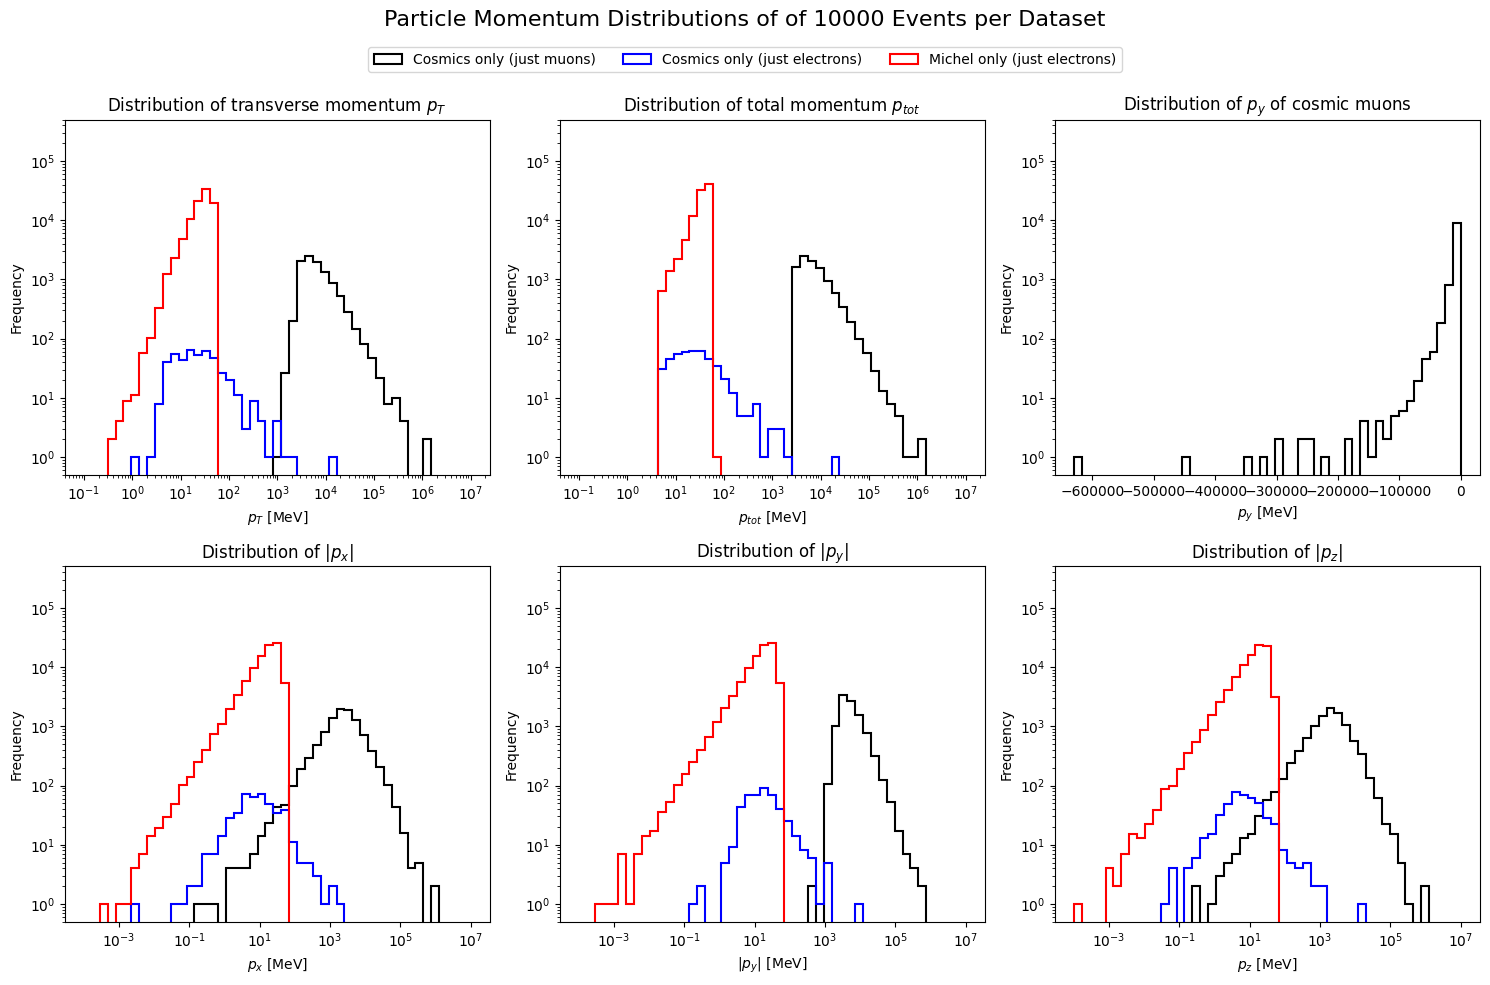

In [12]:
#Momentum plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0,0].hist(pt_c[0], bins=np.logspace(-1, 7, 50), linewidth=1.5, edgecolor='black', histtype='step', label='Cosmics only (just muons)')
axs[0,0].hist(pt_c[1], bins=np.logspace(-1, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step', label='Cosmics only (just electrons)')
#axs[0,0].hist(pt_m[0], bins=np.logspace(-1, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step', label='Michel only (just muons)')
axs[0,0].hist(pt_m[1], bins=np.logspace(-1, 7, 50), linewidth=1.5, edgecolor='red', histtype='step', label='Michel only (just electrons)')
#axs[0,0].hist(pt_cm[0], bins=np.logspace(-1, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step', label='Cosmics with Michel (just muons)')
#axs[0,0].hist(pt_cm[1], bins=np.logspace(-1, 7, 50), linewidth=1.5, edgecolor='green', histtype='step', label='Cosmic with Michel (just electrons)')
axs[0,0].set_ylim(0.5,5*10**5)
axs[0,0].set_xlabel(r'$p_T$ [MeV]')
axs[0,0].set_title(r'Distribution of transverse momentum $p_T$')

axs[0,1].hist(p_tot_c[0], bins=np.logspace(-1, 7, 50), linewidth=1.5, edgecolor='black', histtype='step')
axs[0,1].hist(p_tot_c[1], bins=np.logspace(-1, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step')
#axs[0,1].hist(p_tot_m[0], bins=np.logspace(-1, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step')
axs[0,1].hist(p_tot_m[1], bins=np.logspace(-1, 7, 50), linewidth=1.5, edgecolor='red', histtype='step')
#axs[0,1].hist(p_tot_cm[0], bins=np.logspace(-1, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step', label='Cosmic Michel (just muons)')
#axs[0,1].hist(p_tot_cm[1], bins=np.logspace(-1, 7, 50), linewidth=1.5, edgecolor='green', histtype='step', label='Cosmic Michel (just electrons)')
axs[0,1].set_ylim(0.5,5*10**5)
axs[0,1].set_xlabel(r'$p_{tot}$ [MeV]')
axs[0,1].set_title(r'Distribution of total momentum $p_{tot}$')

axs[0,2].hist(p_mu_c[1], bins=50, linewidth=1.5, edgecolor='black', histtype='step')
#axs[0,2].hist(p_e_c[1], bins=50, linewidth=1.5, edgecolor='blue', histtype='step')
#axs[0,2].hist(p_e_m[1], bins=50, linewidth=1.5, edgecolor='red', histtype='step')
axs[0,2].set_ylim(0.5,5*10**5)
axs[0,2].set_xlabel(r'${p_y}$ [MeV]')
axs[0,2].set_title(r'Distribution of $p_y$ of cosmic muons')

axs[1,0].hist(np.abs(p_mu_c[0]), bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='black', histtype='step')
axs[1,0].hist(np.abs(p_e_c[0]), bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step')
#axs[1,0].hist(p_mu_m[0], bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step')
axs[1,0].hist(np.abs(p_e_m[0]), bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='red', histtype='step')
#axs[1,0].hist(p_mu_cm[0], bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step')
#axs[1,0].hist(p_e_cm[0], bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='green', histtype='step')
#axs[1,0].hist(p_mu_cm[0], bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step')
#axs[1,0].hist(p_e_cm[0], bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='green', histtype='step')
axs[1,0].set_ylim(0.5,5*10**5)
axs[1,0].set_xlabel(r'$p_x$ [MeV]')
axs[1,0].set_title(r'Distribution of $|p_x|$')

axs[1,1].hist(np.abs(p_mu_c[1]), bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='black', histtype='step')
axs[1,1].hist(np.abs(p_e_c[1]), bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step')
#axs[1,1].hist(np.abs(p_mu_m[1]), bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step')
axs[1,1].hist(np.abs(p_e_m[1]), bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='red', histtype='step')
#axs[1,1].hist(np.abs(p_mu_cm[1]), bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step')
#axs[1,1].hist(np.abs(p_e_cm[1]), bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='green', histtype='step')
axs[1,1].set_ylim(0.5,5*10**5)
axs[1,1].set_xlabel(r'$|{p_y}|$ [MeV]')
axs[1,1].set_title(r'Distribution of $|p_y|$')

axs[1,2].hist(np.abs(p_mu_c[2]), bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='black', histtype='step')
axs[1,2].hist(np.abs(p_e_c[2]), bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step')
#axs[1,2].hist(p_mu_m[2], bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step')
axs[1,2].hist(np.abs(p_e_m[2]), bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='red', histtype='step')
#axs[1,2].hist(p_mu_cm[2], bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='blue', histtype='step')
#axs[1,2].hist(p_e_cm[2], bins=np.logspace(-4, 7, 50), linewidth=1.5, edgecolor='green', histtype='step')
axs[1,2].set_ylim(0.5,5*10**5)
axs[1,2].set_xlabel(r'$p_z$ [MeV]')
axs[1,2].set_title(r'Distribution of $|p_z|$')

for ax in axs.flat:
    ax.set_ylabel('Frequency')
    ax.set_yscale('log')
    ax.set_xscale('log')

axs[0,2].set_xscale('linear')

fig.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.95))
plt.tight_layout(rect=[0, 0, 1, 0.91])
fig.suptitle('Particle Momentum Distributions of of 10000 Events per Dataset', fontsize=16)
fig.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/thesis_collection/momentum_plots.pdf', format="pdf", bbox_inches="tight")
plt.show()

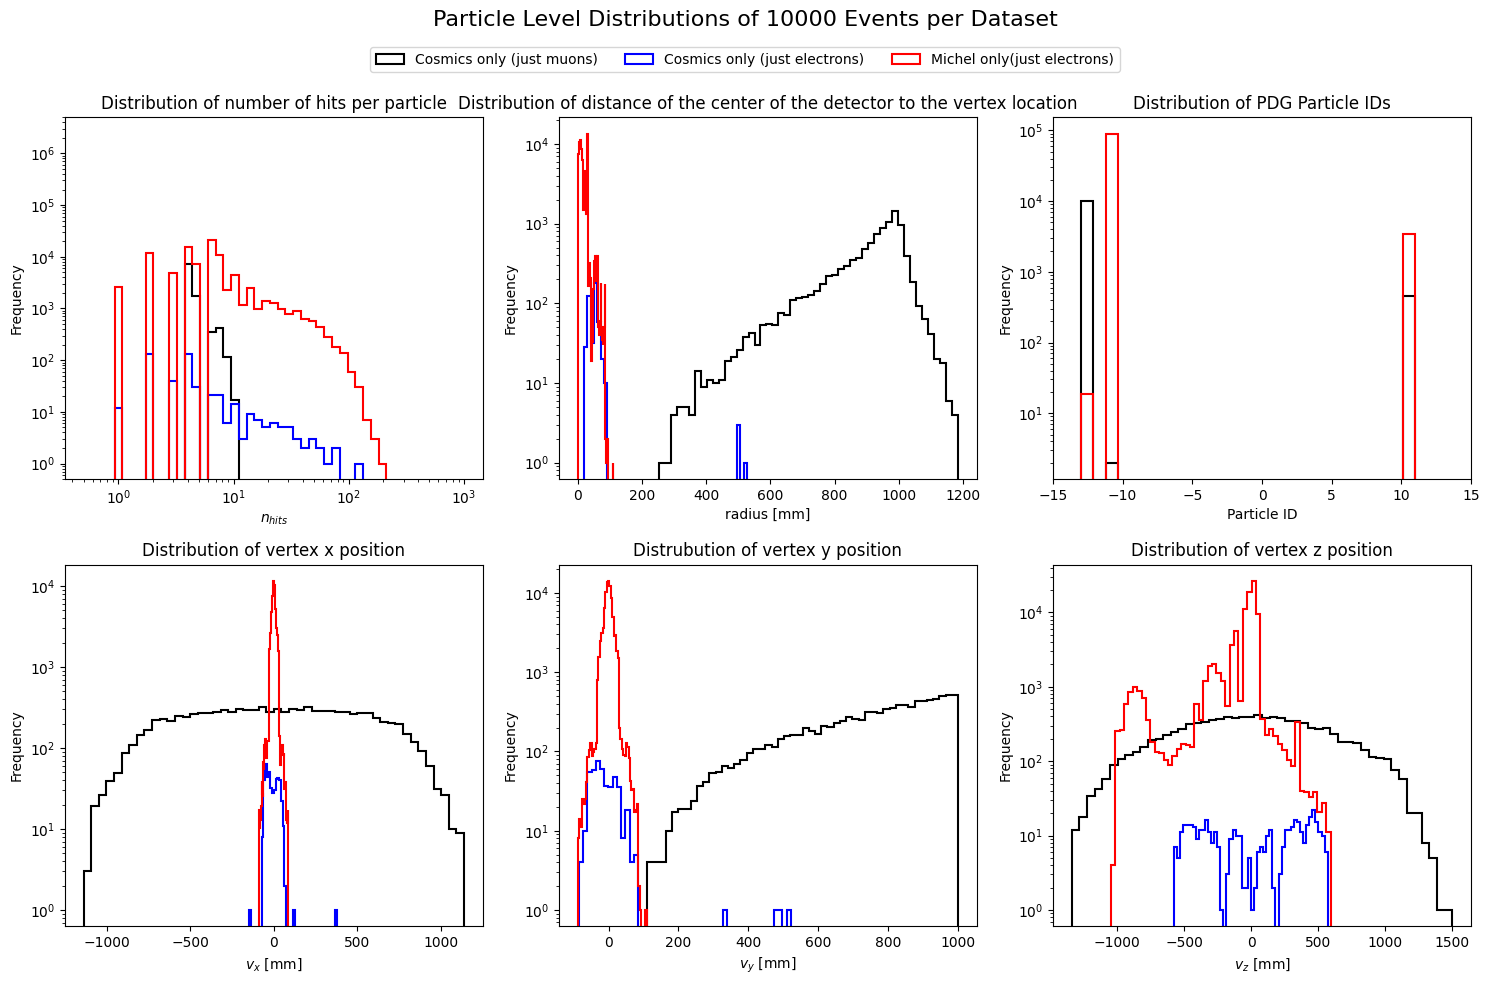

In [13]:
#Other particle level plots

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0,0].hist(nhits_c[0], bins=np.logspace(np.log10(0.5), 3, 50), linewidth=1.5, edgecolor='black', histtype='step', label='Cosmics only (just muons)')
axs[0,0].hist(nhits_c[1], bins=np.logspace(np.log10(0.5), 3, 50), linewidth=1.5, edgecolor='blue', histtype='step', label='Cosmics only (just electrons)')
axs[0,0].hist(nhits_m[1], bins=np.logspace(np.log10(0.5), 3, 50), linewidth=1.5, edgecolor='red', histtype='step', label='Michel only(just electrons)')
#axs[0,0].hist(nhits_cm[0], bins=np.logspace(np.log10(0.5), 3, 50), linewidth=1.5, edgecolor='blue', histtype='step', label='Cosmic Michel (just muons)')
#axs[0,0].hist(nhits_cm[1], bins=np.logspace(np.log10(0.5), 3, 50), linewidth=1.5, edgecolor='green', histtype='step', label='Cosmic Michel (just electrons)')
axs[0,0].set_xlabel(r'$n_{hits}$')
axs[0,0].set_xscale('log')
axs[0,0].set_ylim(0.5,5*10**6)
axs[0,0].set_title('Distribution of number of hits per particle')

axs[0,1].hist(radius_c[0], bins=50, linewidth=1.5, edgecolor='black', histtype='step')
axs[0,1].hist(radius_c[1], bins=50, linewidth=1.5, edgecolor='blue', histtype='step')
axs[0,1].hist(radius_m[1], bins=50, linewidth=1.5, edgecolor='red', histtype='step')
#axs[0,1].hist(radius_cm[0], bins=50, linewidth=1.5, edgecolor='blue', histtype='step', label='Cosmic Michel (just muons)')
#axs[0,1].hist(radius_cm[1], bins=50, linewidth=1.5, edgecolor='green', histtype='step', label='Cosmic Michel (just electrons)')
axs[0,1].set_xlabel('radius [mm]')
axs[0,1].set_title('Distribution of distance of the center of the detector to the vertex location')

axs[0,2].hist(pid_c, bins=27, linewidth=1.5, edgecolor='black', histtype='step')
axs[0,2].hist(pid_m, bins=27, linewidth=1.5, edgecolor='red', histtype='step')
#axs[0,2].hist(pid_cm, bins=27, linewidth=1.5, edgecolor='red', histtype='step', label='Cosmic Michel')
axs[0,2].set_xlabel('Particle ID')
axs[0,2].set_xlim(-15,15)
axs[0,2].set_title('Distribution of PDG Particle IDs')

axs[1,0].hist(v_mu_c[0], bins=50, linewidth=1.5, edgecolor='black', histtype='step')
axs[1,0].hist(v_e_c[0], bins=50, linewidth=1.5, edgecolor='blue', histtype='step')
axs[1,0].hist(v_e_m[0], bins=50, linewidth=1.5, edgecolor='red', histtype='step')
#axs[1,0].hist(v_mu_cm[0], bins=50, linewidth=1.5, edgecolor='blue', histtype='step', label='Cosmic Michel (just muons)')
#axs[1,0].hist(v_e_cm[0], bins=50, linewidth=1.5, edgecolor='green', histtype='step', label='Cosmic Michel (just electrons)')
axs[1,0].set_xlabel(r'$v_x$ [mm]')
axs[1,0].set_title('Distribution of vertex x position')

axs[1,1].hist(v_mu_c[1], bins=50, linewidth=1.5, edgecolor='black', histtype='step')
axs[1,1].hist(v_e_c[1], bins=50, linewidth=1.5, edgecolor='blue', histtype='step')
axs[1,1].hist(v_e_m[1], bins=50, linewidth=1.5, edgecolor='red', histtype='step')
#axs[1,1].hist(v_mu_cm[1], bins=50, linewidth=1.5, edgecolor='blue', histtype='step', label='Cosmic Michel (just muons)')
#axs[1,1].hist(v_e_cm[1], bins=50, linewidth=1.5, edgecolor='green', histtype='step', label='Cosmic Michel (just electrons)')
axs[1,1].set_xlabel(r'$v_y$ [mm]')
axs[1,1].set_title('Distrubution of vertex y position')

axs[1,2].hist(v_mu_c[2], bins=50, linewidth=1.5, edgecolor='black', histtype='step')
axs[1,2].hist(v_e_c[2], bins=50, linewidth=1.5, edgecolor='blue', histtype='step')
axs[1,2].hist(v_e_m[2], bins=50, linewidth=1.5, edgecolor='red', histtype='step')
#axs[1,2].hist(v_mu_cm[2], bins=50, linewidth=1.5, edgecolor='blue', histtype='step', label='Cosmic Michel (just muons)')
#axs[1,2].hist(v_e_cm[2], bins=50, linewidth=1.5, edgecolor='green', histtype='step', label='Cosmic Michel (just electrons)')
axs[1,2].set_xlabel(r'$v_z$ [mm]')
axs[1,2].set_title('Distribution of vertex z position')

for ax in axs.flat:
    ax.set_ylabel('Frequency')
    ax.set_yscale('log')

fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.95))
plt.tight_layout(rect=[0, 0, 1, 0.91])
fig.suptitle('Particle Level Distributions of 10000 Events per Dataset', fontsize=16)
fig.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/thesis_collection/particle_level_plots.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [25]:
import glob
import shutil
import os
import pandas as pd

#Find problematic events
dir = '/mnt/data1/karres/cosmics_test/fully_connected_cm_m_mixed/'

i = 0
for dataset in ['trainset', 'valset', 'testset']:
    weird_dir = dir+'weird_events/'+dataset+'/'
    os.makedirs(weird_dir, exist_ok=True)

    for graph_dir in glob.glob(dir+dataset+'/*.pyg'):
        graph = torch.load(graph_dir)

        if graph.x.shape[0] == graph.track_edges.shape[1]:
            i += 1
            shutil.move(graph_dir, dir+'weird_events/')

print(i)

0


In [29]:
import torch
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt

#Plot histograms of edge level features
dir = '/mnt/data1/karres/cosmics_test/feature_store_cosmic_michel/trainset/event000000001-graph.pyg' 
dir2 = '/mnt/data1/karres/cosmics_test/fully_connected_cosmic_michel/trainset/event000000001.pyg'
dir3 = '/mnt/data1/karres/Example_3/feature_store/trainset/event000021000-graph.pyg'

graph = torch.load(dir)
fc_graph = torch.load(dir2)
tml_graph = torch.load(dir3)

#print(graph)
print(fc_graph.config[1])
#print(tml_graph)

{'stage': 'graph_construction', 'model': 'FullyConnected', 'input_dir': '/mnt/data1/karres/cosmics_test/feature_store_cosmic_michel/', 'stage_dir': '/mnt/data1/karres/cosmics_test/fully_connected_cosmic_michel/', 'project': 'CosmicGNN', 'data_split': [10562, 1320, 1320], 'max_workers': 128}


In [8]:
import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
import os

def hit_id_to_particle_id_map(graph):
    track_edges = graph.track_edges
    particle_types = graph.particle_type

    hit_to_particle_map = {}

    for edge, pid in zip(track_edges.T, particle_types):
        for hit_id in edge:
            hit_to_particle_map[hit_id.item()] = pid.item()

    return hit_to_particle_map

def create_hit_particle_dict(graph):
    '''
    Input: feature store directory, set (trainset, valset, testset) and graph
    Output: Dictionary with hit_id as keys and particle_type as values
    '''
    feature_store = graph.config[1]['input_dir']
    eid = graph.event_id

    if os.path.isfile(feature_store+'trainset'+'/'+f'event{eid}-truth.csv'):
        truth_dir = feature_store+'trainset'+'/'+f'event{eid}-truth.csv'
        particles_dir = feature_store+'trainset'+'/'+f'event{eid}-particles.csv'

    elif os.path.isfile(feature_store+'valset'+'/'+f'event{eid}-truth.csv'):
        truth_dir = feature_store+'valset'+'/'+f'event{eid}-truth.csv'
        particles_dir = feature_store+'valset'+'/'+f'event{eid}-particles.csv'

    else:
        truth_dir = feature_store+'testset'+'/'+f'event{eid}-truth.csv'
        particles_dir = feature_store+'testset'+'/'+f'event{eid}-particles.csv'

    particles_df = pd.read_csv(particles_dir)
    truth_df = pd.read_csv(truth_dir)

    # Merge the dataframes on particle_id
    merged_df = pd.merge(truth_df[['hit_id', 'particle_id']], particles_df[['particle_id', 'particle_type']], on='particle_id')

    # Create the dictionary with hit_id as keys and particle_type as values
    hit_particle_dict = dict(zip(merged_df['hit_id'], merged_df['particle_type']))

    return hit_particle_dict

def get_particle_id(hit_id, hit_to_particle_map):
    return hit_to_particle_map.get(hit_id, 11)
    
    #If hit id not found in hit_to_particle_map return 11 (electron)
    #Map based on truth graph -> Hit id not found <=> This particle only has 1 hit -> probably electron

def get_num_hits(graph):
    #hit_to_particle_map = hit_id_to_particle_id_map(graph)
    hit_to_particle_map = create_hit_particle_dict(graph)
    
    num_muon_hits = 0

    for hit_id in hit_to_particle_map.keys():
        if hit_to_particle_map[hit_id]**2 == 13**2:
            num_muon_hits += 1

    num_electron_hits = graph.x.shape[0] - num_muon_hits

    return num_muon_hits, num_electron_hits

def remove_particle_edges(edges_list, particle_type, map):
    '''
    Input: edge_index or track_edges, pdg ID to be removed and mapping from hit id to pdg ID
    Output: edge_index or track_edges without edges corresponding to the specified pdg ID
    '''
    remove = []
    for index, edge in enumerate(edges_list.T):
        pid1 = get_particle_id(edge[0].item(), map)
        pid2 = get_particle_id(edge[1].item(), map)

        if pid1**2 == particle_type**2 or pid2**2 == particle_type**2: #keeps all edges not containing any particle_type hits
            remove.append(index)
        
    edges_list = np.delete(edges_list.T, remove, axis=0).T
    return edges_list

def sort_and_convert_to_set(edges_list):
    sorted_edges = torch.sort(edges_list.T, dim=1)[0]
    set_edges = set(tuple(row.tolist()) for row in sorted_edges)
    return set_edges

def convert_to_tensor(set_edges):
    return torch.tensor(list(set_edges)).T

def get_num_edges(graph):
    edge_index = graph.edge_index
    track_edges = graph.track_edges

    #hit_to_particle_map = hit_id_to_particle_id_map(graph)
    hit_to_particle_map = create_hit_particle_dict(graph)

    true_muon_edges = remove_particle_edges(track_edges, 11, hit_to_particle_map) #remove all edges from track_edges containing electron hits -> leave truth muons
    num_truth_muon_edges = true_muon_edges.shape[1]

    #Remove truth muon edges from edge_index
    true_muon_edges_set = sort_and_convert_to_set(true_muon_edges)
    edge_index_set = sort_and_convert_to_set(edge_index)

    background_edges_set = edge_index_set - true_muon_edges_set
    background_edges = convert_to_tensor(background_edges_set)
    num_background_edges = background_edges.shape[1]

    return num_truth_muon_edges, num_background_edges

In [9]:
dir = '/mnt/data1/karres/cosmics_test/fully_connected_cosmic_michel/trainset/*.pyg'

#Graph level control plots: num_nodes, num_edges

def compute_hits_edges_stats(dir, samplesize):

    muon_hits = []
    electron_hits = []

    truth_muon_edges = []
    fake_muon_edges = []
    background_edges = []

    i=0

    for graph in glob.glob(dir):
        graph = torch.load(graph)

        num_muon_hits, num_electron_hits = get_num_hits(graph)
        truth_muon, background = get_num_edges(graph)

        muon_hits.append(num_muon_hits)
        electron_hits.append(num_electron_hits)

        truth_muon_edges.append(truth_muon)
        background_edges.append(background)

        if i >samplesize:
            break

        i+=1
    return muon_hits, electron_hits, truth_muon_edges, background_edges

def plot_hits_edge_stats(dir, samplesize, titles=['Cosmics with Michel', 'Cosmics with Michel, fully connected'], filename='num_hits_edges'):
    '''
    Creates plots of the number of hits and edges in 'samplesize' graphs from the directory 'dir'
    Optional: titles for the plots and filename for saving the plots
    '''

    muon_hits, electron_hits, truth_muon_edges, background_edges = compute_hits_edges_stats(dir, samplesize)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].hist(muon_hits, bins=np.logspace(0,2,50), edgecolor='black', linewidth=1.2, histtype='step', label='Muon hits')
    axs[0].hist(electron_hits, bins=np.logspace(0, 3, 50), edgecolor='red', linewidth=1.2, histtype='step', label='Electron hits')
    axs[0].set_xlabel('Number of hits')
    axs[0].set_ylabel('Frequency')
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].legend()
    axs[0].set_title('Distribution of hits ('+titles[0]+')')
    axs[0].grid(True)

    axs[1].hist(truth_muon_edges, bins=np.logspace(0,2,50), edgecolor='black', linewidth=1.2, histtype='step', label='Signal edges (true muon edges)')
    axs[1].hist(background_edges, bins=np.logspace(0,6,50), edgecolor='red', linewidth=1.2, histtype='step', label='Background edges')
    axs[1].set_xlabel('Number of edges')
    axs[1].set_ylabel('Frequency')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[1].legend()
    axs[1].set_title('Distribution of edges ('+titles[1]+')')
    axs[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.91])
    fig.suptitle(f'Graph Level Distributions of {samplesize} Fully Connected Graphs (Cosmics with Michel)', fontsize=16)
    fig.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/thesis_collection/graph_level_plots.pdf', format="pdf", bbox_inches="tight")
    plt.show()

    print('Mean number of muon hits:', np.mean(muon_hits))
    print('Mean number of electron hits:', np.mean(electron_hits))
    print('Mean number of truth muon edges:', np.mean(truth_muon_edges))
    print('Mean number of background edges:', np.mean(background_edges))

In [10]:
#Edge level control plots: angle and distance between hits

def edge_distance_angle(graph):
    edge_index = graph.edge_index
    track_edges = graph.track_edges

    truth_muon_distances = []
    truth_muon_angles = []
    
    background_distances = []
    background_angles = []

    #hit_to_particle_map = hit_id_to_particle_id_map(graph)
    hit_to_particle_map = create_hit_particle_dict(graph)

    true_muon_edges = remove_particle_edges(track_edges, 11, hit_to_particle_map)

    truth_muon_set = sort_and_convert_to_set(true_muon_edges)
    edge_index_set = sort_and_convert_to_set(edge_index)

    background_set = edge_index_set - truth_muon_set

    background_edges = convert_to_tensor(background_set)
    
    for edge in background_edges.T:
        node1 = edge[0].item()
        node2 = edge[1].item()

        node1_pos = graph.node_pos[node1].numpy()
        node2_pos = graph.node_pos[node2].numpy()

        distance = np.linalg.norm(node1_pos - node2_pos)
        y = np.abs(node2_pos[1]-node1_pos[1])
        angle = np.arccos(y/distance)

        background_distances.append(distance)
        background_angles.append(angle)
    
    for edge in true_muon_edges.T:
        node1 = edge[0].item()
        node2 = edge[1].item()
        
        node1_pos = graph.node_pos[node1].numpy()
        node2_pos = graph.node_pos[node2].numpy()

        distance = np.linalg.norm(node1_pos - node2_pos)
        y = np.abs(node2_pos[1]-node1_pos[1])
        angle = np.arccos(y/distance)

        truth_muon_distances.append(distance)
        truth_muon_angles.append(angle)
    return truth_muon_distances, truth_muon_angles, background_distances, background_angles

In [11]:
dir = '/mnt/data1/karres/cosmics_test/fully_connected_cosmic_michel_distance_cut_300/trainset/*.pyg'

def compute_distance_angle_stats(dir, samplesize):

    truth_muon_distances = []
    truth_muon_angles = []
    background_distances = []
    background_angles = []

    i=0

    for graph in glob.glob(dir):
        graph = torch.load(graph)
        truth_muon_d, truth_muon_a, background_d, background_a = edge_distance_angle(graph)

        truth_muon_distances.extend(truth_muon_d)
        truth_muon_angles.extend(truth_muon_a)
        background_distances.extend(background_d)
        background_angles.extend(background_a)

        if i >samplesize:
            break

        i+=1
    
    return truth_muon_distances, truth_muon_angles, background_distances, background_angles

def plot_distance_angle_stats(dir, samplesize, title='Cosmic Michel, fully connected', filename='edge_distance_angle'):

    truth_muon_distances, truth_muon_angles, background_distances, background_angles = compute_distance_angle_stats(dir, samplesize)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].hist(truth_muon_distances, bins=50, edgecolor='black', linewidth=1.2, histtype='step', label='Signal edges (truth muon edges)')
    axs[0].hist(background_distances, bins=50, edgecolor='red', linewidth=1.2, histtype='step', label='Background edges')
    axs[0].set_xlabel('Distance between hits [mm]')
    axs[0].set_ylabel('Frequency')
    axs[0].set_yscale('log')
    axs[0].set_xlim(-20, 1220)
    axs[0].legend()
    axs[0].set_title('Distribution of edge distances')
    axs[0].grid(True)

    axs[1].hist(truth_muon_angles, bins=50, edgecolor='black', linewidth=1.2, histtype='step', label='Signal edges (true muon edges)')
    axs[1].hist(background_angles, bins=50, edgecolor='red', linewidth=1.2, histtype='step', label='Background edges')
    axs[1].set_xlabel('Polar angle [rad]')
    axs[1].set_ylabel('Frequency')
    axs[1].set_yscale('log')
    axs[1].set_xlim(-0.1, np.pi/2+0.1)
    axs[1].legend()
    axs[1].set_title('Distribution of edge angles')
    axs[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.91])
    fig.suptitle(f'Edge Level Distributions of {samplesize} Fully Connected Graphs (Cosmics with Michel)', fontsize=16)
    fig.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/thesis_collection/edge_level_plots.pdf', format="pdf", bbox_inches="tight")
    plt.show()
    
    print('Avg distance signal edges: ', np.mean(truth_muon_distances))
    print('Avg distance background edges: ', np.mean(background_distances))
    print('Avg angle signal edges: ', np.mean(truth_muon_angles))
    print('Avg angle background edges: ', np.mean(background_angles))


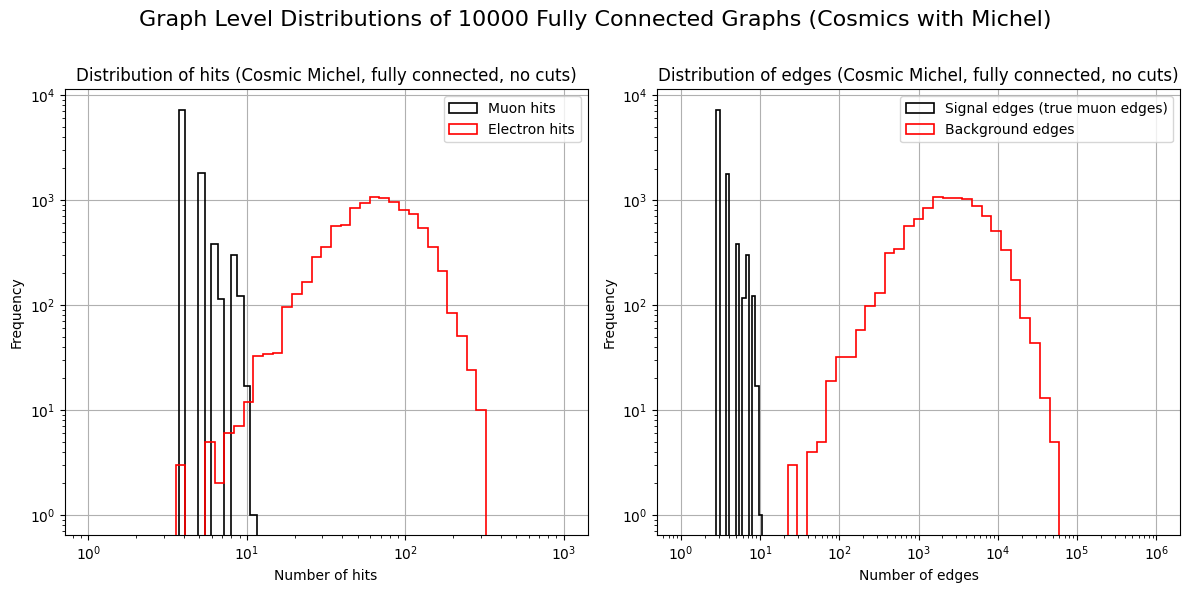

Mean number of muon hits: 4.48130373925215
Mean number of electron hits: 75.250349930014
Mean number of truth muon edges: 3.48000399920016
Mean number of background edges: 3951.5324935012995


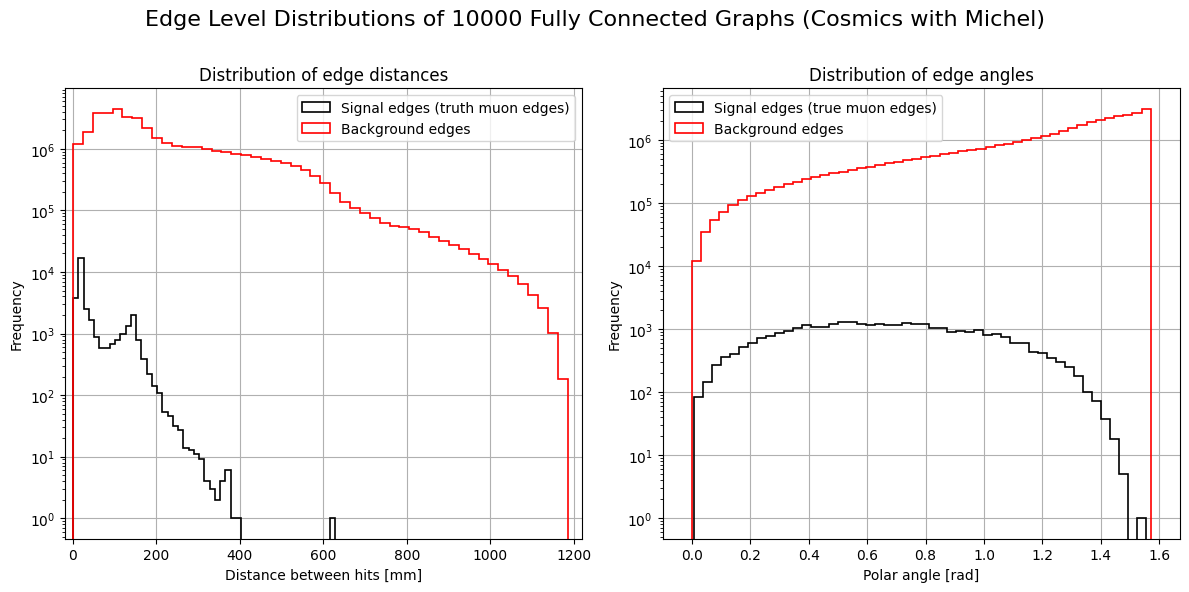

Avg distance signal edges:  47.64114856386963
Avg distance background edges:  214.00317708089764
Avg angle signal edges:  0.6698816330708691
Avg angle background edges:  1.1797166981314549


In [117]:
dir_uncut = '/mnt/data1/karres/cosmics_test/fully_connected_cosmic_michel_uncut/trainset/*.pyg'

plot_hits_edge_stats(dir_uncut, 10000, titles=['Cosmic Michel, fully connected, no cuts', 'Cosmic Michel, fully connected, no cuts'], filename='graph_level_control')
plot_distance_angle_stats(dir_uncut, 10000, title='Cosmic Michel, fully connected, no cuts', filename='edge_level_control')

In [ ]:
import pandas as pd
import numpy as np
import os
import glob

weird_path = '/mnt/data1/karres/cosmics_test/fully_connected_cm_m_mixed/weird_events/'

def find_weird_events(weird_path):
    ptots = []
    particle_types = []

    for weird_path in glob.glob(weird_path+'/*.pyg'):
        csv_path = weird_path.replace('.pyg', '-truth.csv')
        csv_path = csv_path.replace('fully_connected_cosmic_michel/weird_events', 'feature_store_cosmic_michel/trainset')

        if not os.path.exists(csv_path):
            csv_path = csv_path.replace('trainset', 'valset')

            if not os.path.exists(csv_path):
                csv_path = csv_path.replace('valset', 'testset')

        truth_df = pd.read_csv(csv_path)

        weird_hit = truth_df[truth_df.duplicated(subset=['particle_id', 'layer_id', 'ladder_id', 'module_id', 'station_id'], keep=False)]

        ptot = np.unique(np.sqrt(weird_hit['px'].values**2 + weird_hit['py'].values**2 + weird_hit['pz'].values**2))
        particle_id = np.unique(weird_hit['particle_id'].values)

        particle_path = csv_path.replace('-truth.csv', '-particles.csv')
        particle_df = pd.read_csv(particle_path)

        particle_df = particle_df[particle_df['particle_id'].isin(particle_id)]
        particle_type = particle_df['particle_type'].tolist()

        ptots.extend(ptot)
        particle_types.extend(particle_type)

    return ptots, particle_types

def plot_weird_events(dir):
    ptots, particle_types = find_weird_events(dir)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].hist(ptots, bins=50, edgecolor='black', linewidth=1.2, histtype='step')
    axs[0].set_xlabel('p_tot [MeV]')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Distribution of total momenta of problematic hits (Cosmic Michel)')
    axs[0].grid(True)

    axs[1].hist(particle_types, bins=27, edgecolor='black', linewidth=1.2, histtype='step')
    axs[1].set_xlabel('pdgID')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Distribution of pdgIDs of problematic hits (Cosmic Michel)')
    axs[1].grid(True)

    plt.tight_layout()
    plt.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/control_plots/weird_hits.png', dpi=400)
    plt.show()

In [12]:
import numpy as np
import glob
import torch
import scipy
import matplotlib.pyplot as plt
from typing import List

def hit_id_to_particle_id_map(graph):
    track_edges = graph.track_edges
    particle_types = graph.particle_type

    hit_to_particle_map = {}

    for edge, pid in zip(track_edges.T, particle_types):
        for hit_id in edge:
            hit_to_particle_map[hit_id.item()] = pid.item()

    return hit_to_particle_map

def get_particle_id(hit_id, hit_to_particle_map):
    return hit_to_particle_map.get(hit_id, 11)
    
    #If hit id not found in hit_to_particle_map return 11 (electron)
    #Map based on truth graph -> Hit id not found <=> This particle only has 1 hit -> probably electron

def remove_particle_edges(edges_list, particle_type, map):
    '''
    Input: edge_index or track_edges, pdg ID to be removed and mapping from hit id to pdg ID
    Output: edge_index or track_edges without edges corresponding to the specified pdg ID
    '''
    remove = []
    for index, edge in enumerate(edges_list.T):
        pid1 = get_particle_id(edge[0].item(), map)
        pid2 = get_particle_id(edge[1].item(), map)

        if pid1**2 == particle_type**2 or pid2**2 == particle_type**2: #keeps all edges not containing any particle_type hits
            remove.append(index)
        
    edges_list = np.delete(edges_list.T, remove, axis=0).T
    return edges_list

def sort_and_convert_to_set(edges_list):
    sorted_edges = torch.sort(edges_list.T, dim=1)[0]
    set_edges = set(tuple(row.tolist()) for row in sorted_edges)
    return set_edges

def convert_to_tensor(set_edges):
    return torch.tensor(list(set_edges)).T

def get_graph_numbers(dir):
    graph = torch.load(dir)

    num_total_edges = graph.edge_index.shape[1] if graph.edge_index.shape[0] == 2 else 0

    if num_total_edges == 0:
        return 0, 0, 0
    
    #hit_to_particle_map = hit_id_to_particle_id_map(graph)
    hit_to_particle_map = create_hit_particle_dict(graph)

    true_muon_edges = remove_particle_edges(graph.track_edges, 11, hit_to_particle_map)

    num_true_muon_edges = true_muon_edges.shape[1] if true_muon_edges.shape[0] == 2 else 0
    if num_true_muon_edges == 0:
        return num_total_edges, 0, 0
    
    edge_index_set = sort_and_convert_to_set(graph.edge_index)
    true_muon_set = sort_and_convert_to_set(true_muon_edges)


    true_muon_edges_in_edge_index_set = edge_index_set.intersection(true_muon_set)
    true_muon_edges_in_edge_index = convert_to_tensor(true_muon_edges_in_edge_index_set)

    num_true_muon_edges_in_edge_index = true_muon_edges_in_edge_index.shape[1] if true_muon_edges_in_edge_index.shape[0] == 2 else 0

    return num_total_edges, num_true_muon_edges, num_true_muon_edges_in_edge_index

def clopper_pearson(passed: int, total: int, level: float = 0.68):
    """
    Estimate the confidence interval for a sampled binomial random variable with Clopper-Pearson.
    `passed` = number of successes; `total` = number trials; `level` = the confidence level.
    The function returns a `(low, high)` pair of numbers indicating the lower and upper error bars.
    """
    alpha = (1 - level) / 2
    lo = scipy.stats.beta.ppf(alpha, passed, total - passed + 1) if passed > 0 else 0.0
    hi = (
        scipy.stats.beta.ppf(1 - alpha, passed + 1, total - passed)
        if passed < total
        else 1.0
    )
    average = passed / total
    return (average - lo, hi - average)

def compute_graph_numbers(dir, samplesize):
    num_total_edges = 0
    num_true_muon_edges = 0
    num_true_muon_edges_in_edge_index = 0

    i=0

    for graph in glob.glob(dir):
        nte, ntme, ntmee = get_graph_numbers(graph)
        num_total_edges += nte
        num_true_muon_edges += ntme
        num_true_muon_edges_in_edge_index += ntmee

        if i > samplesize:
            break

        i+=1

    eff = num_true_muon_edges_in_edge_index/num_true_muon_edges
    eff_err = np.array(clopper_pearson(num_true_muon_edges_in_edge_index, num_true_muon_edges))

    pur = num_true_muon_edges/num_total_edges
    pur_err = np.array(clopper_pearson(num_true_muon_edges, num_total_edges))

    num_edges = num_total_edges/samplesize
    num_edges_err = num_edges/np.sqrt(num_total_edges)

    return eff, eff_err, pur, pur_err, num_edges, num_edges_err

/tmp/ipykernel_2436007/3619160575.py:48: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/TensorShape.cpp:3614.)
  return torch.tensor(list(set_edges)).T


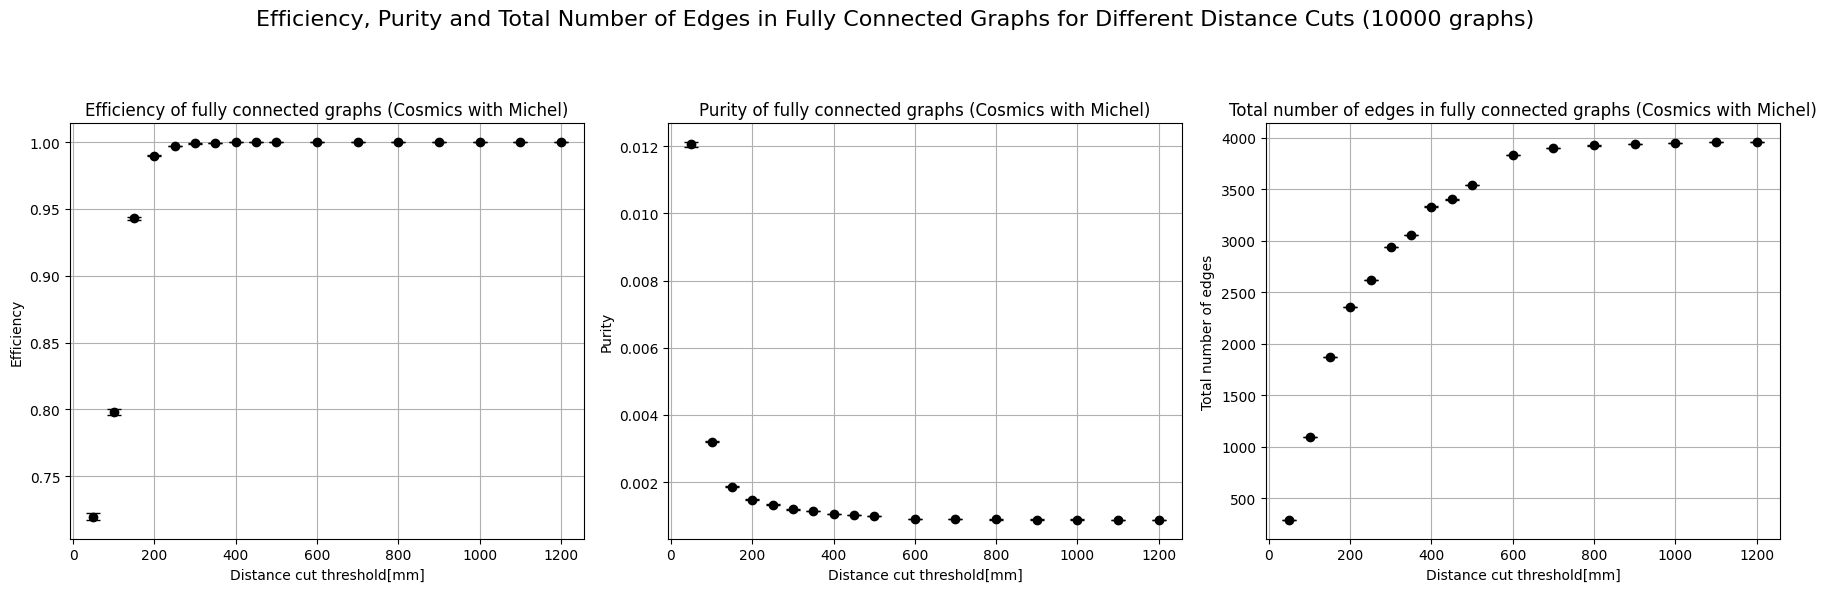

"\n\nfig, axs = plt.subplots(1,3, figsize=(18, 6))\n\naxs[0].errorbar(angles, efficiencies_angle, yerr=efficiencies_err_angle.T, fmt='o', color='black', label='Angle cut', capsize=5)\naxs[0].set_xlabel('Angle cut threshold [rad]')\naxs[0].set_ylabel('Efficiency') \n\naxs[1].errorbar(angles, purities_angle, yerr=purities_err_angle.T, fmt='o', color='black', capsize=5)\naxs[1].set_xlabel('Angle cut threshold [rad]')\naxs[1].set_ylabel('Purity')\n\naxs[2].errorbar(angles, num_edges_angle, yerr=num_edges_err_angle, fmt='o', color='black', capsize=5)   \naxs[2].set_xlabel('Angle cut threshold [rad]')\naxs[2].set_ylabel('Total number of edges')\n\naxs[0].set_title('Efficiency of fully connected graphs (Cosmic Michel)')\naxs[1].set_title('Purity of fully connected graphs (Cosmic Michel)')\naxs[2].set_title('Total number of edges in fully connected graphs (Cosmic Michel)')\n\naxs[0].grid(True)\naxs[1].grid(True)\naxs[2].grid(True)\n\nfig.suptitle('Efficiency, Purity and Total Number of Edges i

In [13]:
import re

distance_cut_dir = '/mnt/data1/karres/cosmics_test/distance_cut_datasets/'
angle_cut_dir = '/mnt/data1/karres/cosmics_test/angle_cut_datasets/'

distance_cuts = sorted(os.listdir(distance_cut_dir))
distance_cuts = sorted(distance_cuts, key=lambda d: int(re.search(r'\d+', d).group()))

angle_cuts = os.listdir(angle_cut_dir)
angle_cuts = sorted(angle_cuts, key=lambda d: int(re.search(r'\d+', d).group()))

distances = [int(re.search(r'\d+', distance).group()) for distance in distance_cuts]
angles = [float(re.search(r'\d+', angle).group())*np.pi/1000 for angle in angle_cuts]

efficiencies_distance = []
efficiencies_err_distance = np.empty((0,2))
purities_distance = []
purities_err_distance = np.empty((0,2))
num_edges_distance = []
num_edges_err_distance = []

for dir in distance_cuts:
    eff, eff_err, pur, pur_err, num_edges, num_edges_err = compute_graph_numbers(distance_cut_dir+dir+'/trainset/*.pyg', 10000)
    efficiencies_distance.append(eff)
    efficiencies_err_distance = np.vstack((efficiencies_err_distance,eff_err))
    purities_distance.append(pur)
    purities_err_distance = np.vstack((purities_err_distance, pur_err))
    num_edges_distance.append(num_edges)
    num_edges_err_distance.append(num_edges_err)
'''
efficiencies_angle = []
efficiencies_err_angle = np.empty((0,2))
purities_angle = []
purities_err_angle = np.empty((0,2))
num_edges_angle = []
num_edges_err_angle = []

for dir in angle_cuts:
    eff, eff_err, pur, pur_err, num_edges, num_edges_err = compute_graph_numbers(angle_cut_dir+dir+'/trainset/*.pyg', 10000)
    efficiencies_angle.append(eff)
    efficiencies_err_angle = np.vstack((efficiencies_err_angle,eff_err))
    purities_angle.append(pur)
    purities_err_angle = np.vstack((purities_err_angle, pur_err))
    num_edges_angle.append(num_edges)
    num_edges_err_angle.append(num_edges_err)
'''
fig, axs = plt.subplots(1,3, figsize=(18, 6))

axs[0].errorbar(distances, efficiencies_distance, yerr=efficiencies_err_distance.T, fmt='o', color='black', label='Distance cut', capsize=5)
axs[0].set_xlabel('Distance cut threshold[mm]')
axs[0].set_ylabel('Efficiency')

axs[1].errorbar(distances, purities_distance, yerr=purities_err_distance.T, fmt='o', color='black', capsize=5)
axs[1].set_xlabel('Distance cut threshold[mm]')
axs[1].set_ylabel('Purity')

axs[2].errorbar(distances, num_edges_distance, yerr=num_edges_err_distance, fmt='o', color='black', capsize=5)
axs[2].set_xlabel('Distance cut threshold[mm]')
axs[2].set_ylabel('Total number of edges')

axs[0].set_title('Efficiency of fully connected graphs (Cosmics with Michel)')
axs[1].set_title('Purity of fully connected graphs (Cosmics with Michel)')
axs[2].set_title('Total number of edges in fully connected graphs (Cosmics with Michel)')
axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)

fig.suptitle('Efficiency, Purity and Total Number of Edges in Fully Connected Graphs for Different Distance Cuts (10000 graphs)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.91])
fig.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/thesis_collection/eff_pur_dist_cut_avg.pdf', format='pdf', bbox_inches='tight')
plt.show()
'''

fig, axs = plt.subplots(1,3, figsize=(18, 6))

axs[0].errorbar(angles, efficiencies_angle, yerr=efficiencies_err_angle.T, fmt='o', color='black', label='Angle cut', capsize=5)
axs[0].set_xlabel('Angle cut threshold [rad]')
axs[0].set_ylabel('Efficiency') 

axs[1].errorbar(angles, purities_angle, yerr=purities_err_angle.T, fmt='o', color='black', capsize=5)
axs[1].set_xlabel('Angle cut threshold [rad]')
axs[1].set_ylabel('Purity')

axs[2].errorbar(angles, num_edges_angle, yerr=num_edges_err_angle, fmt='o', color='black', capsize=5)   
axs[2].set_xlabel('Angle cut threshold [rad]')
axs[2].set_ylabel('Total number of edges')

axs[0].set_title('Efficiency of fully connected graphs (Cosmic Michel)')
axs[1].set_title('Purity of fully connected graphs (Cosmic Michel)')
axs[2].set_title('Total number of edges in fully connected graphs (Cosmic Michel)')

axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)

fig.suptitle('Efficiency, Purity and Total Number of Edges in Fully Connected Graphs for Different Angle Cuts (10000 graphs)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.91])
fig.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/thesis_collection/eff_pur_angle_cut_avg.pdf', format='pdf', bbox_inches='tight')
'''

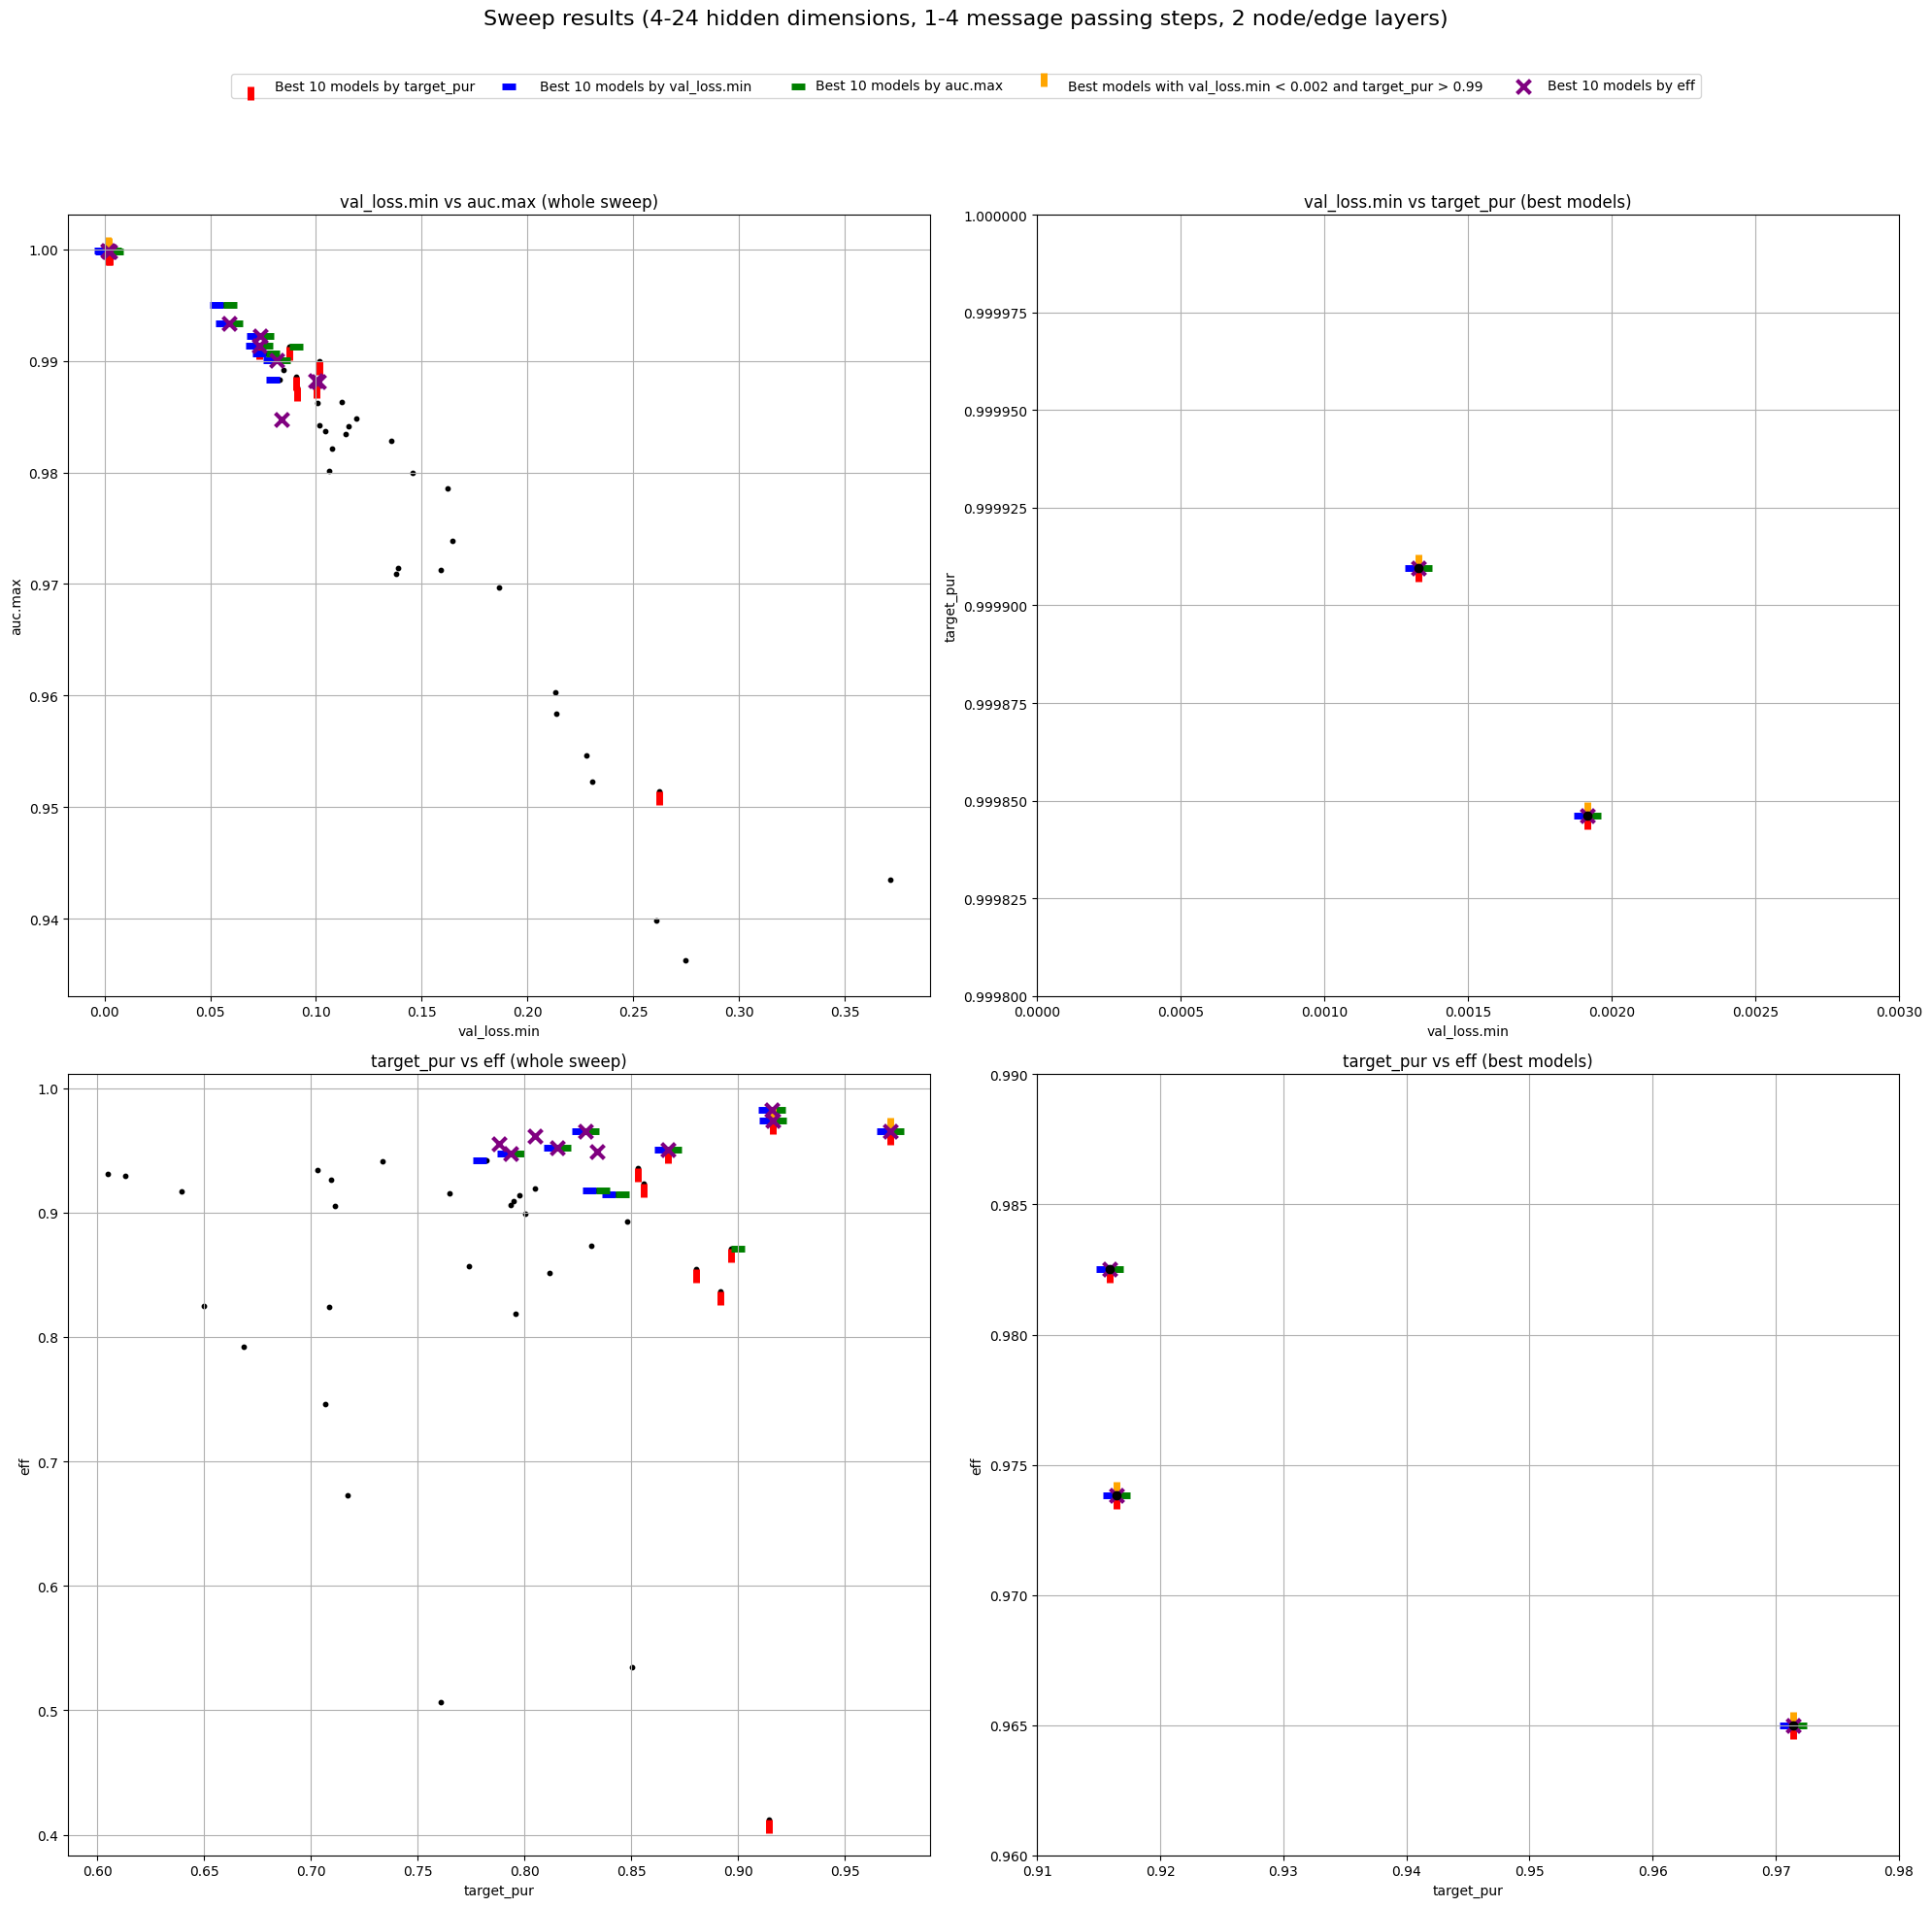

In [30]:
#Analyze Sweep
#Goal: Want model with high target_pur and low val_loss.min while keeping size small

import pandas as pd
import numpy as np

sweep_df = pd.read_csv('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/sweep_results.csv')
#drop = np.array([1,2,3,4,10,12])
#sweep_df = sweep_df.drop(sweep_df.columns[drop], axis=1)
#drop = np.array([7,9,10,11,12,13,15,16])
#sweep_df = sweep_df.drop(sweep_df.columns[drop], axis=1)

sweep_df_val_sorted = sweep_df.sort_values(by='val_loss.min', ascending=True)
sweep_df_pur_sorted = sweep_df.sort_values(by='target_pur', ascending=False)
sweep_df_auc_sorted = sweep_df.sort_values(by='auc.max', ascending=False)
sweep_df_eff_sorted = sweep_df.sort_values(by='eff', ascending=False)

#Print best 10 model names and val_loss.min
best10_val = sweep_df_val_sorted.head(10)
#print(best10_val[['Name', 'val_loss.min']])

#Print best 10 model names and target_pur
best10_pur = sweep_df_pur_sorted.head(10)
#print(best10_pur[['Name', 'target_pur']])

#Print best 10 model names and auc.max
best10_auc = sweep_df_auc_sorted.head(10)
#print(best10_auc[['Name', 'auc.max']])

#Print best 10 model names and eff
best10_eff = sweep_df_eff_sorted.head(10)
#print(best10_eff[['Name', 'eff']])

#Print best 10 model names, target_pur and val_loss.min with val_loss.min < 0.0015
best10_combined_pur = sweep_df_pur_sorted[sweep_df_pur_sorted['val_loss.min'] < 0.002].head(10)
#print(best10_combined_pur[['Name', 'target_pur', 'val_loss.min']])

#Print best 10 model names, target_pur and val_loss.min with target_pur > 0.97
best10_combined_val = sweep_df_val_sorted[sweep_df_val_sorted['target_pur'] > 0.99].head(10)
#print(best10_combined_val[['Name', 'target_pur', 'val_loss.min']])

#Plot target_pur vs val_loss.min
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(20, 20))

axs[0,0].set_xlabel('val_loss.min')
axs[0,0].set_ylabel('auc.max')
axs[0,0].set_title('val_loss.min vs auc.max (whole sweep)')
axs[0,0].grid(True)

axs[0,0].scatter(sweep_df['val_loss.min'], sweep_df['auc.max'], color='black', s=10)
axs[0,0].scatter(best10_pur['val_loss.min'], best10_pur['auc.max'], marker=3, s=100, linewidths=5, color='red', label='Best 10 models by target_pur')
axs[0,0].scatter(best10_val['val_loss.min'], best10_val['auc.max'], marker=0, s=100, linewidths=5, color='blue', label='Best 10 models by val_loss.min')
axs[0,0].scatter(best10_auc['val_loss.min'], best10_auc['auc.max'], marker=1, s=100, linewidths=5, color='green', label='Best 10 models by auc.max')
axs[0,0].scatter(best10_combined_val['val_loss.min'], best10_combined_val['auc.max'], marker=2, s=100, linewidths=5, color='orange', label='Best models with val_loss.min < 0.002 and target_pur > 0.99')
axs[0,0].scatter(best10_combined_pur['val_loss.min'], best10_combined_pur['auc.max'], marker=2, s=100, linewidths=5, color='orange')
axs[0,0].scatter(best10_eff['val_loss.min'], best10_eff['auc.max'], marker='x', s=100, linewidths=3, color='purple', label='Best 10 models by eff')

axs[0,1].set_xlabel('val_loss.min')
axs[0,1].set_ylabel('target_pur')
axs[0,1].set_title('val_loss.min vs target_pur (best models)')
axs[0,1].set_xlim(0, 0.003)
axs[0,1].set_ylim(0.9998, 1)
axs[0,1].grid(True)

axs[0,1].scatter(best10_pur['val_loss.min'], best10_pur['auc.max'], marker=3, s=100, linewidths=5, color='red')
axs[0,1].scatter(best10_val['val_loss.min'], best10_val['auc.max'], marker=0, s=100, linewidths=5, color='blue')
axs[0,1].scatter(best10_auc['val_loss.min'], best10_auc['auc.max'], marker=1, s=100, linewidths=5, color='green')
axs[0,1].scatter(best10_combined_val['val_loss.min'], best10_combined_val['auc.max'], marker=2, s=100, linewidths=5, color='orange')
axs[0,1].scatter(best10_combined_pur['val_loss.min'], best10_combined_pur['auc.max'], marker=2, s=100, linewidths=5, color='orange')
axs[0,1].scatter(best10_eff['val_loss.min'], best10_eff['auc.max'], marker='x', s=100, linewidths=3, color='purple')
axs[0,1].scatter(sweep_df['val_loss.min'], sweep_df['auc.max'], color='black')

axs[1,0].set_xlabel('target_pur')
axs[1,0].set_ylabel('eff')
axs[1,0].set_title('target_pur vs eff (whole sweep)')
axs[1,0].grid(True)

axs[1,0].scatter(sweep_df['target_pur'], sweep_df['eff'], color='black', s=10)
axs[1,0].scatter(best10_pur['target_pur'], best10_pur['eff'], marker=3, s=100, linewidths=5, color='red')
axs[1,0].scatter(best10_val['target_pur'], best10_val['eff'], marker=0, s=100, linewidths=5, color='blue')
axs[1,0].scatter(best10_auc['target_pur'], best10_auc['eff'], marker=1, s=100, linewidths=5, color='green')
axs[1,0].scatter(best10_combined_val['target_pur'], best10_combined_val['eff'], marker=2, s=100, linewidths=5, color='orange')
axs[1,0].scatter(best10_combined_pur['target_pur'], best10_combined_pur['eff'], marker=2, s=100, linewidths=5, color='orange')
axs[1,0].scatter(best10_eff['target_pur'], best10_eff['eff'], marker='x', s=100, linewidths=3, color='purple')

axs[1,1].set_xlabel('target_pur')
axs[1,1].set_ylabel('eff')
axs[1,1].set_title('target_pur vs eff (best models)')
axs[1,1].set_xlim(0.91, 0.98)
axs[1,1].set_ylim(0.96, 0.99)
axs[1,1].grid(True)

axs[1,1].scatter(best10_pur['target_pur'], best10_pur['eff'], marker=3, s=100, linewidths=5, color='red')
axs[1,1].scatter(best10_val['target_pur'], best10_val['eff'], marker=0, s=100, linewidths=5, color='blue')
axs[1,1].scatter(best10_auc['target_pur'], best10_auc['eff'], marker=1, s=100, linewidths=5, color='green')
axs[1,1].scatter(best10_combined_val['target_pur'], best10_combined_val['eff'], marker=2, s=100, linewidths=5, color='orange')
axs[1,1].scatter(best10_combined_pur['target_pur'], best10_combined_pur['eff'], marker=2, s=100, linewidths=5, color='orange')
axs[1,1].scatter(best10_eff['target_pur'], best10_eff['eff'], marker='x', s=100, linewidths=3, color='purple')
axs[1,1].scatter(sweep_df['target_pur'], sweep_df['eff'], color='black')

fig.suptitle('Sweep results (4-24 hidden dimensions, 1-4 message passing steps, 2 node/edge layers)', fontsize=16)
fig.legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5, 0.95))
plt.tight_layout(rect=[0, 0, 1, 0.91])
plt.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/thesis_collection/sweep_results.pdf', format='pdf')

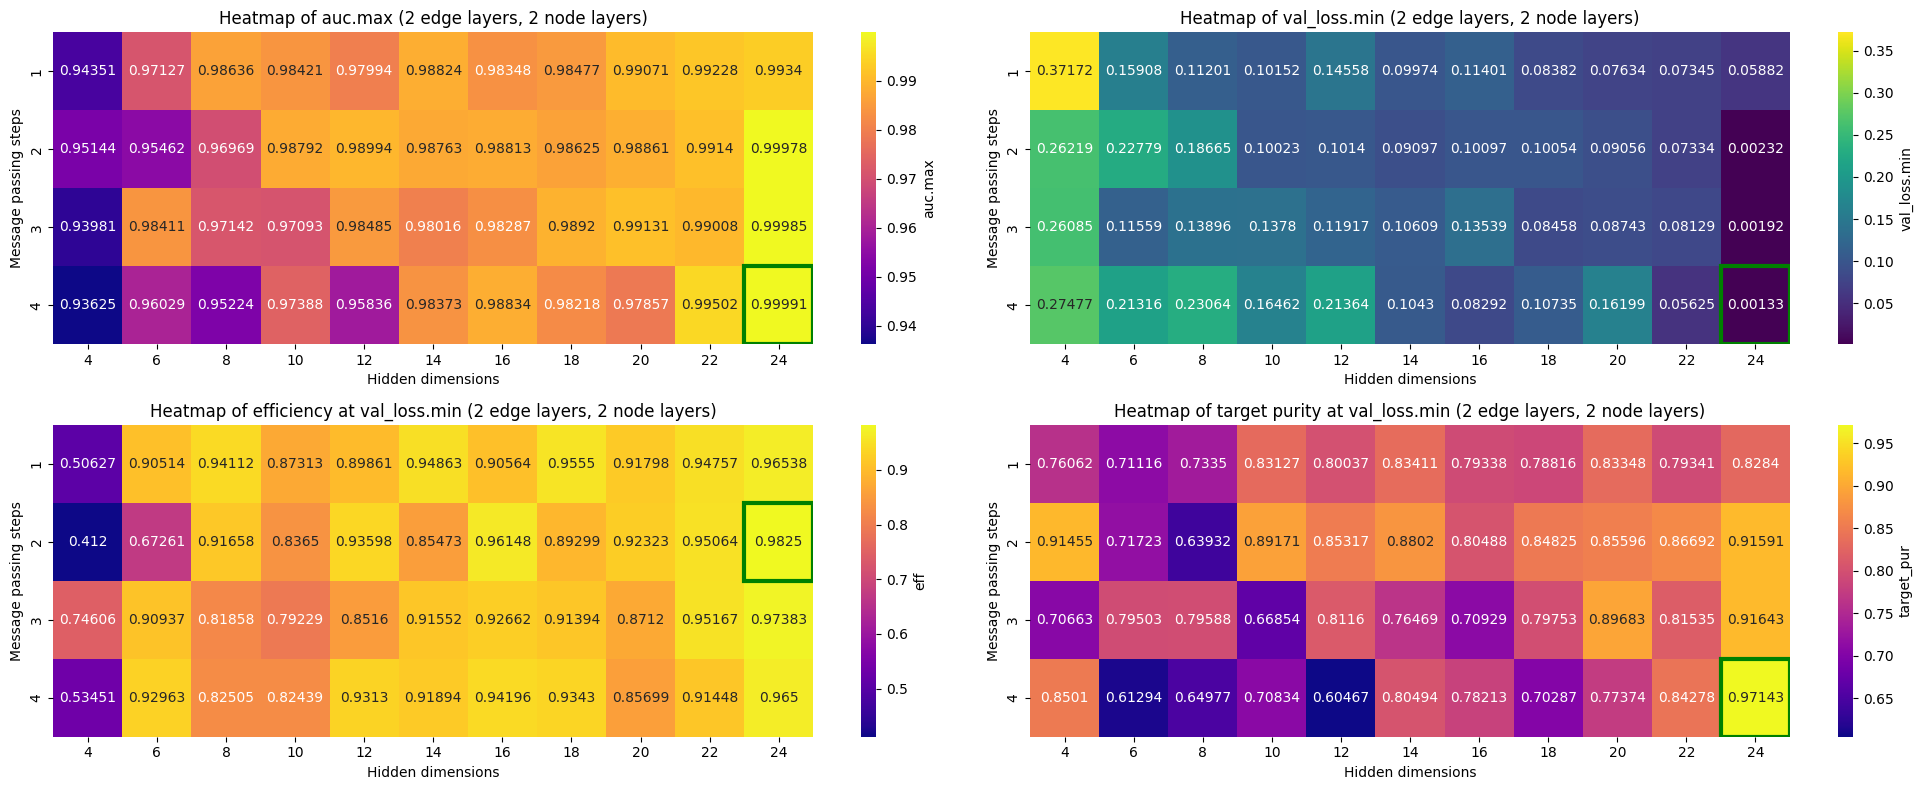

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Filter the DataFrame
filtered_df = sweep_df[(sweep_df['nb_edge_layer'] == 2) & (sweep_df['nb_node_layer'] == 2)]
filtered_df['Name_number'] = filtered_df['Name'].str.split('-').str[-1]

# Step 2: Pivot the DataFrame for 'auc.max', 'val_loss.min', and 'Name_number'
pivot_auc = filtered_df.pivot(index='n_graph_iters', columns='hidden', values='auc.max')
pivot_val_loss = filtered_df.pivot(index='n_graph_iters', columns='hidden', values='val_loss.min')
pivot_name_number = filtered_df.pivot(index='n_graph_iters', columns='hidden', values='Name_number')
pivot_eff = filtered_df.pivot(index='n_graph_iters', columns='hidden', values='eff')
pivot_target_pur = filtered_df.pivot(index='n_graph_iters', columns='hidden', values='target_pur')

# Step 3: Create the figure and the two heatmaps side by side
fig, axes = plt.subplots(2, 2, figsize=(20, 8))

# Heatmap 1: auc.max with Name annotations and max value highlighted
#ax1 = sns.heatmap(pivot_auc, annot=pivot_name_number, fmt='', cmap='plasma', cbar_kws={'label': 'auc.max'}, ax=axes[0])
axes[0,0] = sns.heatmap(pivot_auc, annot=round(pivot_auc,5), fmt='', cmap='plasma', cbar_kws={'label': 'auc.max'}, ax=axes[0,0])

# Find the location of the maximum auc.max value
max_idx_auc = np.unravel_index(np.nanargmax(pivot_auc.values), pivot_auc.shape)

# Highlight the cell with the highest auc.max value
axes[0,0].add_patch(plt.Rectangle((max_idx_auc[1], max_idx_auc[0]), 1, 1, fill=False, edgecolor='green', lw=3))

# Set titles and labels for the first heatmap
axes[0,0].set_title('Heatmap of auc.max (2 edge layers, 2 node layers)')
axes[0,0].set_xlabel('Hidden dimensions')
axes[0,0].set_ylabel('Message passing steps')

# Heatmap 2: val_loss.min with Name annotations and min value highlighted
#ax2 = sns.heatmap(pivot_val_loss, annot=pivot_name_number, fmt='', cmap='plasma', cbar_kws={'label': 'val_loss.min'}, ax=axes[1])
axes[0,1] = sns.heatmap(pivot_val_loss, annot=round(pivot_val_loss,5), fmt='', cmap='viridis', cbar_kws={'label': 'val_loss.min'}, ax=axes[0,1])

# Find the location of the minimum val_loss.min value
min_idx_val_loss = np.unravel_index(np.nanargmin(pivot_val_loss.values), pivot_val_loss.shape)

# Highlight the cell with the lowest val_loss.min value
axes[0,1].add_patch(plt.Rectangle((min_idx_val_loss[1], min_idx_val_loss[0]), 1, 1, fill=False, edgecolor='green', lw=3))

# Set titles and labels for the second heatmap
axes[0,1].set_title('Heatmap of val_loss.min (2 edge layers, 2 node layers)')
axes[0,1].set_xlabel('Hidden dimensions')
axes[0,1].set_ylabel('Message passing steps')

#Eff pur
axes[1,0] = sns.heatmap(pivot_eff, annot=round(pivot_eff,5), fmt='', cmap='plasma', cbar_kws={'label': 'eff'}, ax=axes[1,0])

# Find the location of the maximum auc.max value
max_idx_eff = np.unravel_index(np.nanargmax(pivot_eff.values), pivot_eff.shape)

# Highlight the cell with the highest auc.max value
axes[1,0].add_patch(plt.Rectangle((max_idx_eff[1], max_idx_eff[0]), 1, 1, fill=False, edgecolor='green', lw=3))

# Set titles and labels for the first heatmap
axes[1,0].set_title('Heatmap of efficiency at val_loss.min (2 edge layers, 2 node layers)')
axes[1,0].set_xlabel('Hidden dimensions')
axes[1,0].set_ylabel('Message passing steps')

# Heatmap 2: val_loss.min with Name annotations and min value highlighted
#axes[1,1] = sns.heatmap(pivot_target_pur, annot=pivot_name_number, fmt='', cmap='plasma', cbar_kws={'label': 'target_pur'}, ax=axes[1,1])
axes[1,1] = sns.heatmap(pivot_target_pur, annot=round(pivot_target_pur,5), fmt='', cmap='plasma', cbar_kws={'label': 'target_pur'}, ax=axes[1,1])
max_idx_target_pur = np.unravel_index(np.nanargmax(pivot_target_pur.values), pivot_target_pur.shape)
axes[1,1].add_patch(plt.Rectangle((max_idx_target_pur[1], max_idx_target_pur[0]), 1, 1, fill=False, edgecolor='green', lw=3))

# Set titles and labels for the second heatmap
axes[1,1].set_title('Heatmap of target purity at val_loss.min (2 edge layers, 2 node layers)')
axes[1,1].set_xlabel('Hidden dimensions')
axes[1,1].set_ylabel('Message passing steps')

# Adjust layout
plt.tight_layout()
plt.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/thesis_collection/sweep_heatmap.pdf', format='pdf')
plt.show()

In [6]:
import os
import shutil
import re

def create_mixed_sample(cm_dir, m_dir, c_dir, mixed_dir):
    cm_files = os.listdir(cm_dir)
    m_files = os.listdir(m_dir)
    c_files = os.listdir(c_dir)


    if len(cm_files) <= len(m_files) and len(cm_files) <= len(c_files):
        split= int(len(cm_files)/3)
        print(len(cm_files))
    elif len(m_files) <= len(cm_files) and len(m_files) <= len(c_files):
        split= int(len(m_files)/3)
        print(len(m_files))
    else:
        split= int(len(c_files)/3)
        print(len(c_files))

    print(split)
    
    p = re.compile(r'\d+')
    cm_files = sorted(cm_files, key=lambda s: int(p.search(s).group()))
    m_files = sorted(m_files, key=lambda s: int(p.search(s).group()))
    c_files = sorted(c_files, key=lambda s: int(p.search(s).group()))

    for i in range(split):
        file = cm_files[i]
        source_path = os.path.join(cm_dir, file)
        dest_path = os.path.join(mixed_dir, file)
        shutil.copy2(source_path, dest_path)

    j=1
    while j <= split:
        file = m_files[-j]
        source_path = os.path.join(m_dir, file)
        dest_path = os.path.join(mixed_dir, file)
        shutil.copy2(source_path, dest_path)
        j+=1

    k=1
    while k <= split:
        file = c_files[split+k]
        source_path = os.path.join(c_dir, file)
        dest_path = os.path.join(mixed_dir, file)
        shutil.copy2(source_path, dest_path)
        k+=1

cm_dir = '/mnt/data1/karres/cosmics_test/fully_connected_cosmic_michel/valset'
m_dir = '/mnt/data1/karres/cosmics_test/fully_connected_michel/valset'
c_dir = '/mnt/data1/karres/cosmics_test/fully_connected_cosmic/valset'

mixed_dir = '/mnt/data1/karres/cosmics_test/fully_connected_cm_m_c_mixed/valset'

create_mixed_sample(cm_dir, m_dir, c_dir, mixed_dir)

1299
433


In [19]:
import torch
import numpy as np
import pandas as pd
from visualization_utils_v2 import *

dir = '/mnt/data1/karres/cosmics_test/connected_components/track_recon_cosmic_with_michel/testset/event000000026.pyg'
#dir = '/mnt/data1/karres/cosmics_test/connected_components/track_recon_cosmic_only/testset/event000000026.pyg'


graph = torch.load(dir)
print(graph.event_id)
#print(graph.node_pos)
print(graph.scores)

map = hit_id_to_particle_id_map(graph)
muon_edges = remove_particle_edges(graph.track_edges, 11, map)
print(muon_edges)
#print(graph.track_edges)

track_dir = '/mnt/data1/karres/cosmics_test/connected_components/track_recon_cosmic_with_michel/testset_tracks/event000000026.txt'
#track_dir  = '/mnt/data1/karres/cosmics_test/connected_components/track_recon_cosmic_only/testset_tracks/event000000026.txt'
print(pd.read_csv(track_dir, sep=' ').to_string(index=False))

['000000026']
tensor([0.0064, 0.0400, 0.0467,  ..., 0.0005, 0.0005, 0.0005])
Building map
Error: Hit id not found in hit_to_particle_map
Setting missing hit ids to 0
Missing hit ids: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 1

In [1]:
import torch
from visualization_utils_v2 import *

'''
Track: at least 3 hits connected by >=2 edges
    -> How to check if hits are connected by edges?
    -> Only use track edges?

True track: track with all hits muon hits
Fake track: track with at least one non-muon hit
'''

def read_track_txt(track_dir):
    raw_tracks = []
    with open(track_dir, 'r') as file:
        for track in file:
            track = list(map(int, track.split()))
            raw_tracks.append(track)

    return raw_tracks

def get_tracks(track_dir, min_num_hits):
    '''
    Input: List of track candidates
    Output: List of tracks with at least min_num_hits hits
    '''
    raw_tracks = read_track_txt(track_dir)
    track_candidates = [track for track in raw_tracks if len(track) >= min_num_hits]

    return track_candidates

def get_hit_particle_ids(hit_list, map):
    '''
    Input: List of hits
    Output: List of particle ids for each hit
    '''
    hit_particle_ids = []

    for hit in hit_list:
        hit_particle_ids.append(map[hit]**2)

    return hit_particle_ids

def create_hit_particle_dict(particles_dir, truth_dir):
    '''
    Input: Directories to the particles and truth csv files
    Output: Dictionary with hit_id as keys and particle_type as values
    '''
    particles_df = pd.read_csv(particles_dir)
    truth_df = pd.read_csv(truth_dir)

    # Merge the dataframes on particle_id
    merged_df = pd.merge(truth_df[['hit_id', 'particle_id']], particles_df[['particle_id', 'particle_type']], on='particle_id')

    # Create the dictionary with hit_id as keys and particle_type as values
    hit_particle_dict = dict(zip(merged_df['hit_id'], merged_df['particle_type']))

    return hit_particle_dict

def count_true_fake_tracks(dir, feature_store, min_track_length=3, samplesize=100000):
    num_true = 0
    num_fake = 0
    num_evts = 0
    num_of_tracks = []

    fake_rate = 0
    reco_rate = 0
    quality = 0
    
    for set in ['testset', 'valset', 'trainset']:
        tracks_dir = dir + f'/{set}_tracks'

        for track_txt in os.listdir(tracks_dir):
            num_evts +=1
            if num_evts > samplesize:
                break

            track_path = os.path.join(tracks_dir, track_txt)

            track_candidates = get_tracks(track_path, min_track_length)
            num_of_tracks.append(len(track_candidates))

            if len(track_candidates) == 0:
                continue

            truth_path = '/mnt/data1/karres/cosmics_test'+f'/{feature_store}'+f'/{set}'f'/{track_txt[:-4]}-truth.csv'
            particle_path = '/mnt/data1/karres/cosmics_test'+f'/{feature_store}'+f'/{set}'f'/{track_txt[:-4]}-particles.csv'

            #particle_id_map = hit_id_to_particle_id_map(torch.load(graph_dir))
            particle_id_map = create_hit_particle_dict(particle_path, truth_path)
            true_per_event = 0

            for track in track_candidates:
                hit_particle_ids = get_hit_particle_ids(track, particle_id_map)
                if all(x == 13**2 for x in hit_particle_ids):
                    true_per_event += 1

            if true_per_event >= 1:
                num_true += 1
            else:
                num_fake += 1
            
            if num_true == 0:
                quality = 1
            else:
                quality = num_fake/num_true

            reco_rate = num_true/num_evts
            fake_rate = num_fake/num_evts
    '''
    print('#####################################')
    print(dir)
    print(f'Minimum track length: {min_track_length}')
    print(f'Number of events: {num_evts}')
    print(f'Number of true tracks reconstructed: {num_true}')
    print(f'Number of fake tracks reconstructed: {num_fake}')
    print(f'Mean number of tracks per event: {np.mean(num_of_tracks):.4f}')
    print(f'Std number of tracks per event: {np.std(num_of_tracks):.4f}')
    print(f'Fake track rate: {fake_rate:.4f}')
    print(f'Reconstruction rate: {reco_rate:.4f}')
    print('#####################################')
    print()
    '''
    return fake_rate, reco_rate, quality, num_of_tracks, num_true, num_fake

In [26]:
fake_rates_2 = []
reco_rates_2 = []
quality_2 = []
num_of_tracks_2 = []

fake_rates_3 = []
reco_rates_3 = []
quality_3 = []
num_of_tracks_3 = []

fake_rates_4 = []
reco_rates_4 = []
quality_4 = []
num_of_tracks_4 = []

fake_rates_5 = []
reco_rates_5 = []
quality_5 = []
num_of_tracks_5 = []

dir = '/mnt/data1/karres/cosmics_test/connected_components/score_cut_scan_cosmic_with_michel/'
score_cuts = [int(cut)/100 if int(cut)<100 else int(cut)/1000 for cut in sorted(os.listdir(dir))]
size = 100000
'''
for cut in sorted(os.listdir(dir)):
    new_fake, new_reco, new_quality, new_num = count_true_fake_tracks(dir+cut, 'feature_store_cosmic_michel', 2, size)
    fake_rates_2.append(new_fake)
    reco_rates_2.append(new_reco)
    quality_2.append(new_quality)
    num_of_tracks_2.append(new_num)
'''
for cut in sorted(os.listdir(dir)):
    new_fake, new_reco, new_quality, new_num = count_true_fake_tracks(dir+cut, 'feature_store_cosmic_michel', 3, size)
    fake_rates_3.append(new_fake)
    reco_rates_3.append(new_reco)
    quality_3.append(new_quality)
    num_of_tracks_3.append(new_num)

for cut in sorted(os.listdir(dir)):
    new_fake, new_reco, new_quality, new_num = count_true_fake_tracks(dir+cut, 'feature_store_cosmic_michel', 4, size)
    fake_rates_4.append(new_fake)
    reco_rates_4.append(new_reco)
    quality_4.append(new_quality)
    num_of_tracks_4.append(new_num)
'''
for cut in sorted(os.listdir(dir)):
    new_fake, new_reco, new_quality, new_num = count_true_fake_tracks(dir+cut, 'feature_store_cosmic_michel', 5, size)
    fake_rates_5.append(new_fake)
    reco_rates_5.append(new_reco)
    quality_5.append(new_quality)
    num_of_tracks_5.append(new_num)
    '''

#####################################
/mnt/data1/karres/cosmics_test/connected_components/score_cut_scan_cosmic_with_michel/50
Minimum track length: 3
Number of events: 12000
Number of true tracks reconstructed: 11852
Number of fake tracks reconstructed: 45
Mean number of tracks per event: 1.0012
Std number of tracks per event: 0.1369
Fake track rate: 0.0037
Reconstruction rate: 0.9877
#####################################

#####################################
/mnt/data1/karres/cosmics_test/connected_components/score_cut_scan_cosmic_with_michel/55
Minimum track length: 3
Number of events: 12000
Number of true tracks reconstructed: 11835
Number of fake tracks reconstructed: 53
Mean number of tracks per event: 1.0011
Std number of tracks per event: 0.1423
Fake track rate: 0.0044
Reconstruction rate: 0.9862
#####################################

#####################################
/mnt/data1/karres/cosmics_test/connected_components/score_cut_scan_cosmic_with_michel/60
Minimum track len

"\nfor cut in sorted(os.listdir(dir)):\n    new_fake, new_reco, new_quality, new_num = count_true_fake_tracks(dir+cut, 'feature_store_cosmic_michel', 5, size)\n    fake_rates_5.append(new_fake)\n    reco_rates_5.append(new_reco)\n    quality_5.append(new_quality)\n    num_of_tracks_5.append(new_num)\n    "

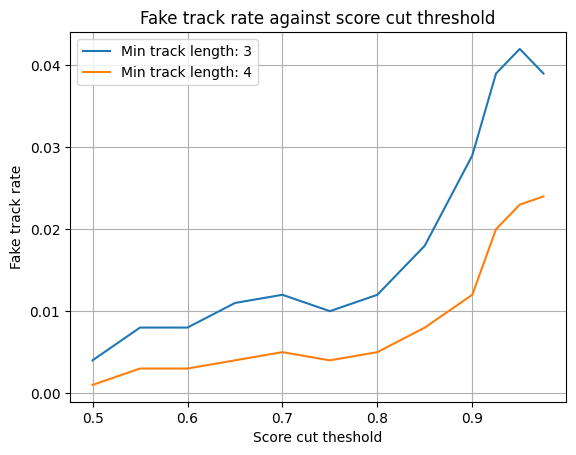

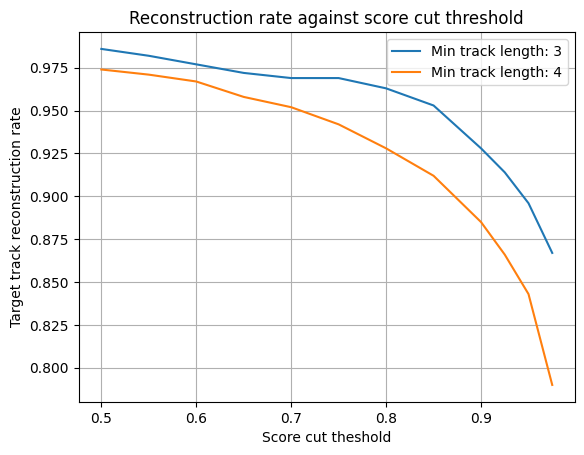

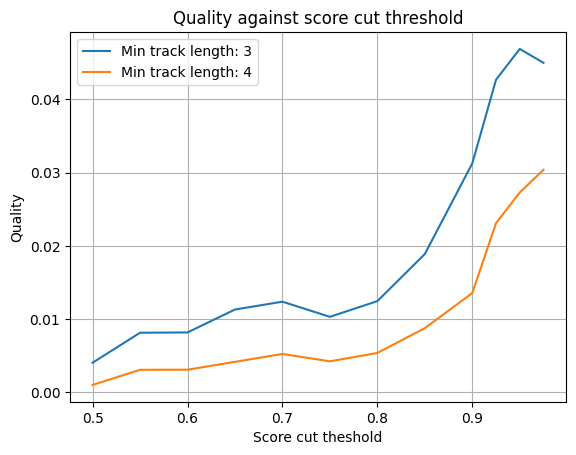

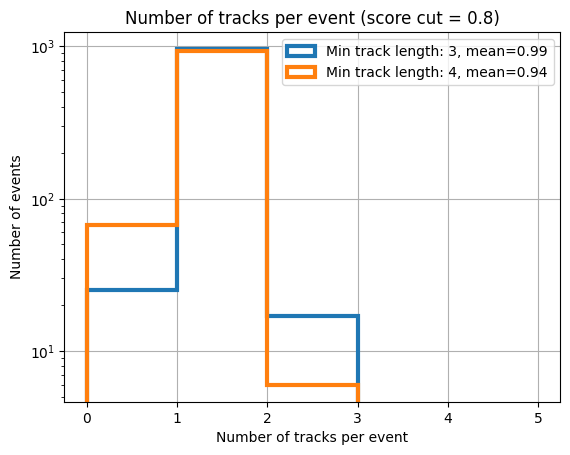

[0.004, 0.008, 0.008, 0.011, 0.012, 0.01, 0.012, 0.018, 0.029, 0.039, 0.042, 0.039]
[0.986, 0.982, 0.977, 0.972, 0.969, 0.969, 0.963, 0.953, 0.928, 0.914, 0.896, 0.867]


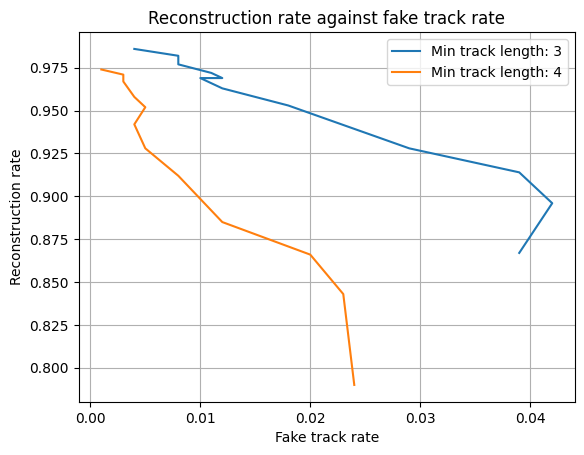

In [25]:
#plt.plot(score_cuts, fake_rates_2, label='Min track length: 2')
plt.plot(score_cuts, fake_rates_3, label='Min track length: 3')
plt.plot(score_cuts, fake_rates_4, label='Min track length: 4')
#plt.plot(score_cuts, fake_rates_5, label='Min track length: 5')
plt.xlabel('Score cut theshold')
plt.ylabel('Fake track rate')
plt.title('Fake track rate against score cut threshold')
plt.legend()
plt.grid(True)
plt.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/thesis_collection/fake_track_rate_score_cut_cm_3_to_4.pdf', format='pdf')
plt.show()

#plt.plot(score_cuts, reco_rates_2, label='Min track length: 2')
plt.plot(score_cuts, reco_rates_3, label='Min track length: 3')
plt.plot(score_cuts, reco_rates_4, label='Min track length: 4')
#plt.plot(score_cuts, reco_rates_5, label='Min track length: 5')
plt.xlabel('Score cut theshold')
plt.ylabel('Target track reconstruction rate')
plt.title('Reconstruction rate against score cut threshold')
plt.legend()
plt.grid(True)
plt.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/thesis_collection/reco_rate_score_cut_cm_3_to_4.pdf', format='pdf')
plt.show()


#plt.plot(score_cuts, quality_2, label='Min track length: 2')
plt.plot(score_cuts, quality_3, label='Min track length: 3')
plt.plot(score_cuts, quality_4, label='Min track length: 4')
#plt.plot(score_cuts, quality_5, label='Min track length: 5')
plt.xlabel('Score cut theshold')
plt.ylabel('Quality')
plt.title('Quality against score cut threshold')
plt.legend()
plt.grid(True)
plt.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/thesis_collection/quality_score_cut_cm_3_to_4.pdf', format='pdf')
plt.show()

'''
labels, counts = np.unique(np.array(num_of_tracks_2[0]), return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
'''
#plt.hist(num_of_tracks_2[6], bins=[0,1,2,3,4,5], label=f'Min track length: 2, mean={np.mean(num_of_tracks_2[6]):.2f}', histtype='step', linewidth=3)
plt.hist(num_of_tracks_3[6], bins=[0,1,2,3,4,5], label=f'Min track length: 3, mean={np.mean(num_of_tracks_3[6]):.2f}', histtype='step', linewidth=3)
plt.hist(num_of_tracks_4[6], bins=[0,1,2,3,4,5], label=f'Min track length: 4, mean={np.mean(num_of_tracks_4[6]):.2f}', histtype='step', linewidth=3)
#plt.hist(num_of_tracks_5[6], bins=[0,1,2,3,4,5], label=f'Min track length: 5, mean={np.mean(num_of_tracks_5[6]):.2f}', histtype='step', linewidth=3)
plt.xlabel('Number of tracks per event')
plt.ylabel('Number of events')
plt.yscale('log')
plt.title('Number of tracks per event (score cut = 0.8)')
plt.legend()
plt.grid(True)
plt.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/thesis_collection/num_tracks_per_event_cm_3_to_4.pdf', format='pdf')
plt.show()

print(fake_rates_3)
print(reco_rates_3)


#plt.plot(fake_rates_2, reco_rates_2, label='Min track length: 2')
plt.plot(fake_rates_3, reco_rates_3, label='Min track length: 3')
plt.plot(fake_rates_4, reco_rates_4, label='Min track length: 4')
#plt.plot(fake_rates_5, reco_rates_5, label='Min track length: 5')
plt.xlabel('Fake track rate')
plt.ylabel('Reconstruction rate')
plt.title('Reconstruction rate against fake track rate')
plt.legend()
plt.grid(True)
plt.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/thesis_collection/reco_rate_fake_rate_cm_3_to_4.pdf', format='pdf')
plt.show()

In [47]:
import pandas as pd
import os
import glob

particles_dir = '/mnt/data1/karres/cosmics_test/feature_store_cosmic_michel/testset/event000000003-particles.csv'
truth_dir = '/mnt/data1/karres/cosmics_test/feature_store_cosmic_michel/testset/event000000003-truth.csv'

def create_hit_particle_dict(particles_dir, truth_dir):
    '''
    Input: Directories to the particles and truth csv files
    Output: Dictionary with hit_id as keys and particle_type as values
    '''
    particles_df = pd.read_csv(particles_dir)
    truth_df = pd.read_csv(truth_dir)

    # Merge the dataframes on particle_id
    merged_df = pd.merge(truth_df[['hit_id', 'particle_id']], particles_df[['particle_id', 'particle_type']], on='particle_id')

    # Create the dictionary with hit_id as keys and particle_type as values
    hit_particle_dict = dict(zip(merged_df['hit_id'], merged_df['particle_type']))

    return hit_particle_dict

for truth_file in glob.glob('/mnt/data1/karres/cosmics_test/feature_store_cosmic_michel/testset/*-truth.csv'):
    particles_file = truth_file.replace('-truth.csv', '-particles.csv')
    hit_particle_dict = create_hit_particle_dict(particles_file, truth_file)

In [4]:
fake_rates_3 = []
reco_rates_3 = []
quality_3 = []
num_of_tracks_3 = []
num_true_3 = []
num_fake_3 = []

fake_rates_4 = []
reco_rates_4 = []
quality_4 = []
num_of_tracks_4 = []
num_true_4 = []
num_fake_4 = []

dir = '/mnt/data1/karres/cosmics_test/thesis_results/cosmics_only/cm_c_gnn/connected_components/'
feature_store = 'feature_store_cosmic'

score_cuts = [int(cut)/100 if int(cut)<100 else int(cut)/1000 for cut in sorted(os.listdir(dir)) if os.path.isdir(os.path.join(dir, cut))]
size = 100000

#dir_list = [cut for cut in sorted(os.listdir(dir)) if os.path.isdir(os.path.join(dir, cut))]

for cut in sorted(os.listdir(dir)):
    new_fake, new_reco, new_quality, new_num, new_num_true, new_num_fake = count_true_fake_tracks(dir+cut, feature_store, 3, size)
    fake_rates_3.append(new_fake)
    reco_rates_3.append(new_reco)
    quality_3.append(new_quality)
    num_of_tracks_3.append(new_num)
    num_true_3.append(new_num_true)
    num_fake_3.append(new_num_fake)

for cut in sorted(os.listdir(dir)):
    new_fake, new_reco, new_quality, new_num, new_num_true, new_num_fake = count_true_fake_tracks(dir+cut, feature_store, 4, size)
    fake_rates_4.append(new_fake)
    reco_rates_4.append(new_reco)
    quality_4.append(new_quality)
    num_of_tracks_4.append(new_num)
    num_true_4.append(new_num_true)
    num_fake_4.append(new_num_fake)

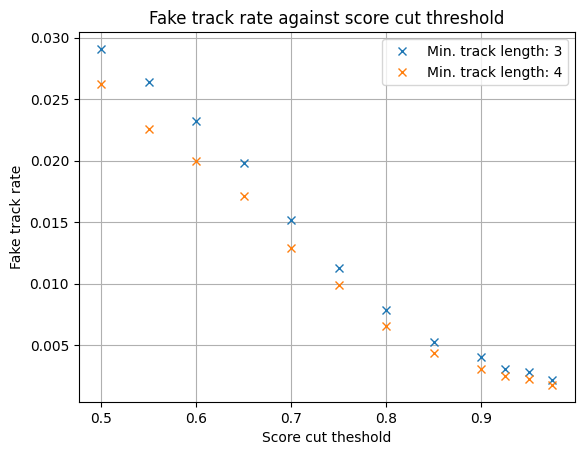

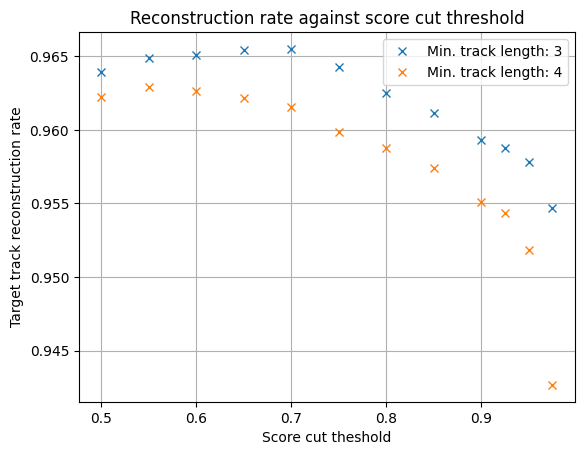

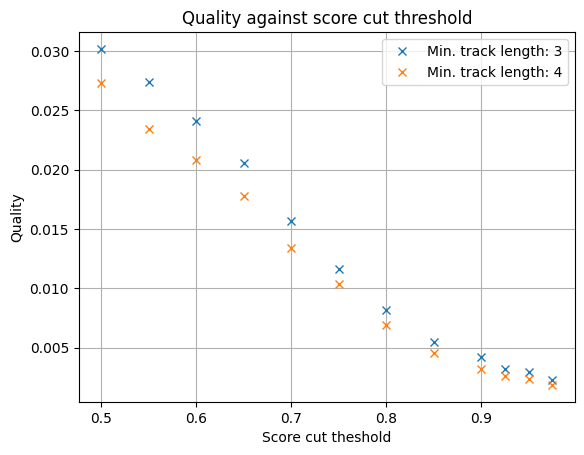

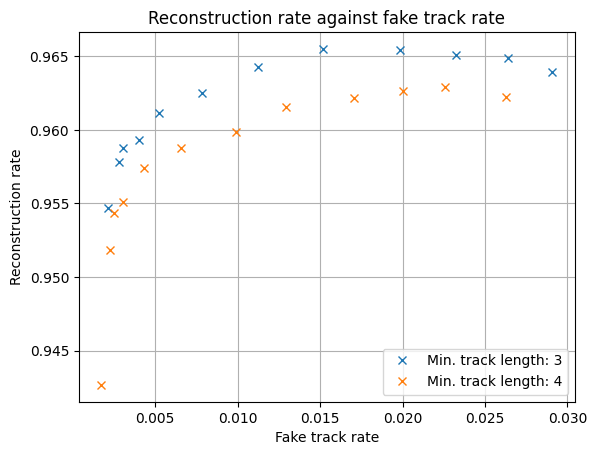

In [5]:
data_to_save = {'fr_3':fake_rates_3, 'rr_3': reco_rates_3, 'q_3': quality_3, 'num_true_3': num_true_3, 'num_fake_3': num_fake_3, 
                'fr_4': fake_rates_4, 'rr_4': reco_rates_4, 'q_4':quality_4, 'num_true_4': num_true_4, 'num_fake_4': num_fake_4}

import pandas as pd

(pd.DataFrame.from_dict(data=data_to_save, orient='index')
   .to_csv(dir+'fake_rate_data.csv', header=False))

plt.plot(score_cuts, fake_rates_3, 'x', label='Min. track length: 3')
plt.plot(score_cuts, fake_rates_4, 'x', label='Min. track length: 4')
plt.xlabel('Score cut theshold')
plt.ylabel('Fake track rate')
plt.title('Fake track rate against score cut threshold')
plt.legend()
plt.grid(True)
plt.savefig(dir+'fake_track_rate_score_cut.pdf', format='pdf')
plt.show()

plt.plot(score_cuts, reco_rates_3, 'x', label='Min. track length: 3')
plt.plot(score_cuts, reco_rates_4, 'x', label='Min. track length: 4')
plt.xlabel('Score cut theshold')
plt.ylabel('Target track reconstruction rate')
plt.title('Reconstruction rate against score cut threshold')
plt.legend()
plt.grid(True)
plt.savefig(dir+'reco_rate_score_cut.pdf', format='pdf')
plt.show()

plt.plot(score_cuts, quality_3, 'x', label='Min. track length: 3')
plt.plot(score_cuts, quality_4, 'x', label='Min. track length: 4')
plt.xlabel('Score cut theshold')
plt.ylabel('Quality')
plt.title('Quality against score cut threshold')
plt.legend()
plt.grid(True)
plt.savefig(dir+'quality_score_cut.pdf', format='pdf')
plt.show()

plt.plot(fake_rates_3, reco_rates_3, 'x', label='Min. track length: 3')
plt.plot(fake_rates_4, reco_rates_4, 'x', label='Min. track length: 4')
plt.xlabel('Fake track rate')
plt.ylabel('Reconstruction rate')
plt.title('Reconstruction rate against fake track rate')
plt.legend()
plt.grid(True)
plt.savefig(dir+'reco_rate_fake_rate.pdf', format='pdf')
plt.show()

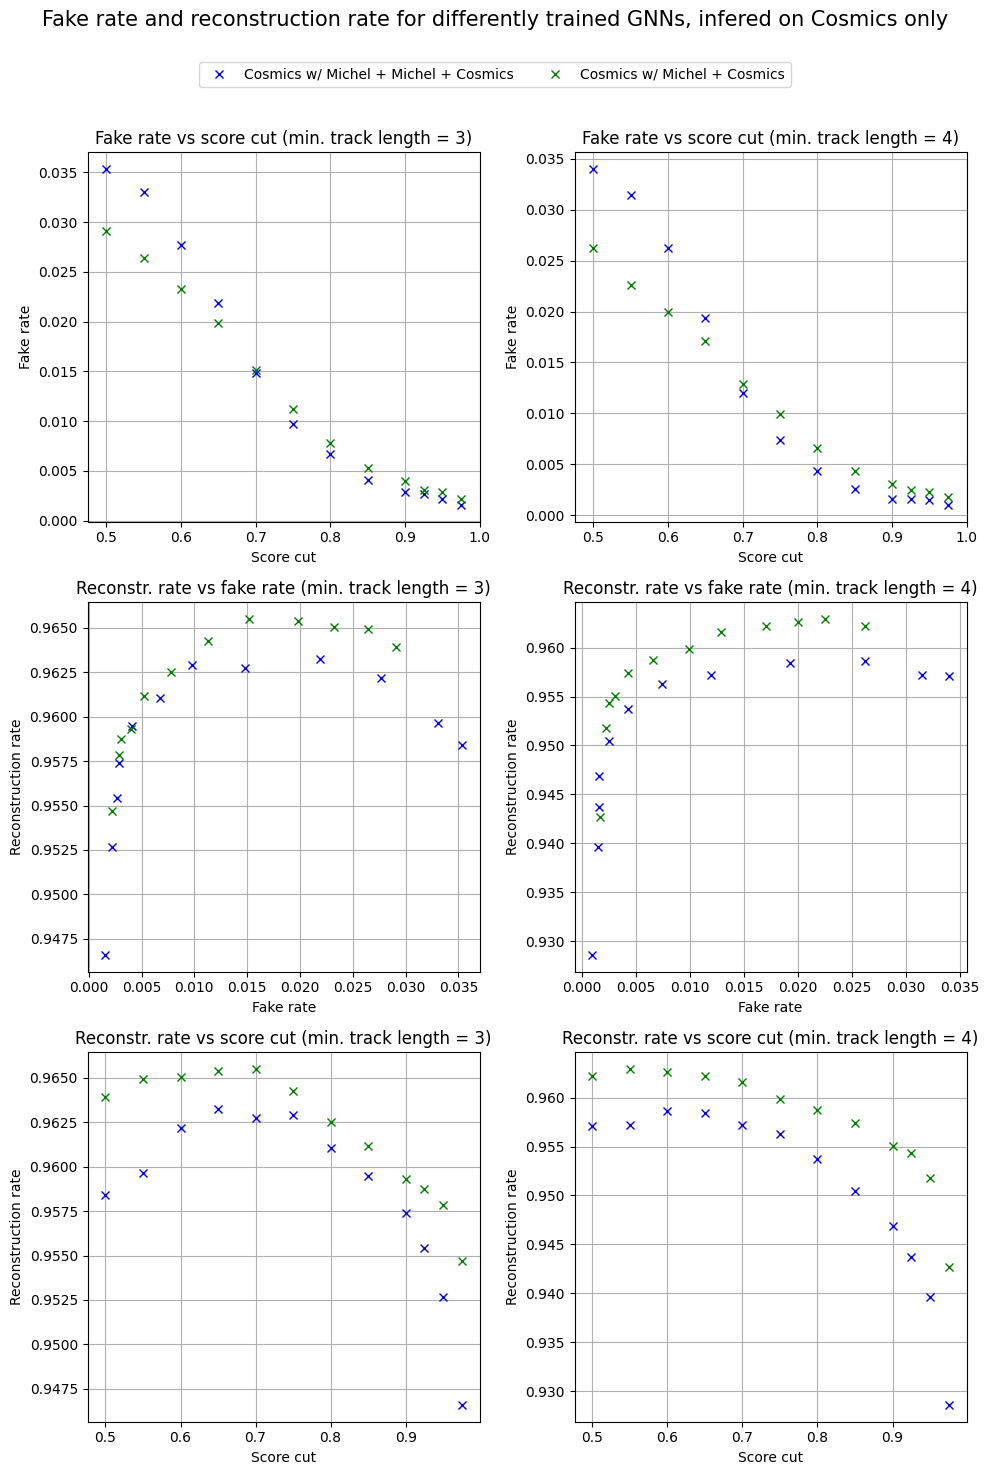

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

cosmics_dir = '/mnt/data1/karres/cosmics_test/thesis_results/cosmics_only/'
michel_dir = '/mnt/data1/karres/cosmics_test/thesis_results/michel_only/'
cosmic_michel_dir = '/mnt/data1/karres/cosmics_test/thesis_results/cosmics_with_michel/'

score_cuts = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975]

gnns = ['cm_m_c_gnn','cm_m_gnn', 'cm_c_gnn', 'cm_gnn']
gnn_names = ['Cosmics w/ Michel + Michel + Cosmics', 'Cosmics w/ Michel + Michel', 'Cosmics w/ Michel + Cosmics', 'Cosmics w/ Michel']
gnn_colours =  ['blue','orange', 'green', 'red']

fig,axs = plt.subplots(3, 2, figsize=(10, 15))

for ax in axs.flat:
    #ax.set_yscale('log')
    ax.grid(True)

axs[0,0].set_xlim(0.475, 1)
axs[0,0].set_title('Fake rate vs score cut (min. track length = 3)')
axs[0,0].set_xlabel('Score cut')
axs[0,0].set_ylabel('Fake rate')

axs[0,1].set_xlim(0.475, 1)
axs[0,1].set_title('Fake rate vs score cut (min. track length = 4)')
axs[0,1].set_xlabel('Score cut')
axs[0,1].set_ylabel('Fake rate')

axs[1,0].set_title('Reconstr. rate vs fake rate (min. track length = 3)')
axs[1,0].set_xlabel('Fake rate')
axs[1,0].set_ylabel('Reconstruction rate')

axs[1,1].set_title('Reconstr. rate vs fake rate (min. track length = 4)')
axs[1,1].set_xlabel('Fake rate')
axs[1,1].set_ylabel('Reconstruction rate')

axs[2,0].set_title('Reconstr. rate vs score cut (min. track length = 3)')
axs[2,0].set_xlabel('Score cut')
axs[2,0].set_ylabel('Reconstruction rate')

axs[2,1].set_title('Reconstr. rate vs score cut (min. track length = 4)')
axs[2,1].set_xlabel('Score cut')
axs[2,1].set_ylabel('Reconstruction rate')

for index, (gnn, gnn_name, colour) in enumerate(zip(gnns, gnn_names, gnn_colours)):
    if index == 1 or index == 3:
        continue

    path = cosmics_dir + gnn + '/connected_components/fake_rate_data.csv'
    data = pd.read_csv(path, header=None, index_col=0)
    data = data.apply(lambda row: row.tolist(), axis=1).to_dict()

    axs[0,0].plot(score_cuts, data['fr_3'], 'x', label=gnn_name, color=colour)
    axs[0,1].plot(score_cuts, data['fr_4'], 'x', label=gnn_name, color=colour)  
    axs[1,0].plot(data['fr_3'], data['rr_3'], 'x', label=gnn_name, color=colour)
    axs[1,1].plot(data['fr_4'], data['rr_4'], 'x', label=gnn_name, color=colour)
    axs[2,0].plot(score_cuts, data['rr_3'], 'x', label=gnn_name, color=colour)
    axs[2,1].plot(score_cuts, data['rr_4'], 'x', label=gnn_name, color=colour)


#put legend outside of plot to the right
line, label = axs[0,0].get_legend_handles_labels()
fig.legend(line, label, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.95))
plt.tight_layout(rect=[0, 0, 1, 0.91])
fig.suptitle('Fake rate and reconstruction rate for differently trained GNNs, infered on Cosmics only', fontsize=15)
fig.savefig('/home/mue/karres/git/Mu3eCosmicGNN/examples/Cosmic_GNN/thesis_collection/fake_reco_rate_cosmics_only_nocmm_nocm.pdf', format='pdf')